In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.preprocessing import LabelEncoder

# Scaling and Splitting
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector as SFS

# Modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


#Unbalance problems
from imblearn.over_sampling import SMOTE

# Evaluation
from sklearn.metrics import f1_score,accuracy_score, precision_score,recall_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, roc_curve,roc_auc_score



import warnings 
warnings.filterwarnings(action='ignore')
sns.set()

In [2]:
df = pd.read_csv("possibleDataset/weatherAUS.csv")
df.isnull().sum(), df.shape

(Date                 0
 Location             0
 MinTemp           1485
 MaxTemp           1261
 Rainfall          3261
 Evaporation      62790
 Sunshine         69835
 WindGustDir      10326
 WindGustSpeed    10263
 WindDir9am       10566
 WindDir3pm        4228
 WindSpeed9am      1767
 WindSpeed3pm      3062
 Humidity9am       2654
 Humidity3pm       4507
 Pressure9am      15065
 Pressure3pm      15028
 Cloud9am         55888
 Cloud3pm         59358
 Temp9am           1767
 Temp3pm           3609
 RainToday         3261
 RainTomorrow      3267
 dtype: int64,
 (145460, 23))

## Data Preprocessing

In [3]:
df = df[df['RainTomorrow'].notna() & df['RainToday'].notna() & df['Sunshine'].notna()]

### Categorical Data

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df0 = df.copy()
df = df.drop('RainTomorrow',axis=1)
df['Month'] = df['Date'].dt.month
df['RainTomorrow'] = df0['RainTomorrow'] 

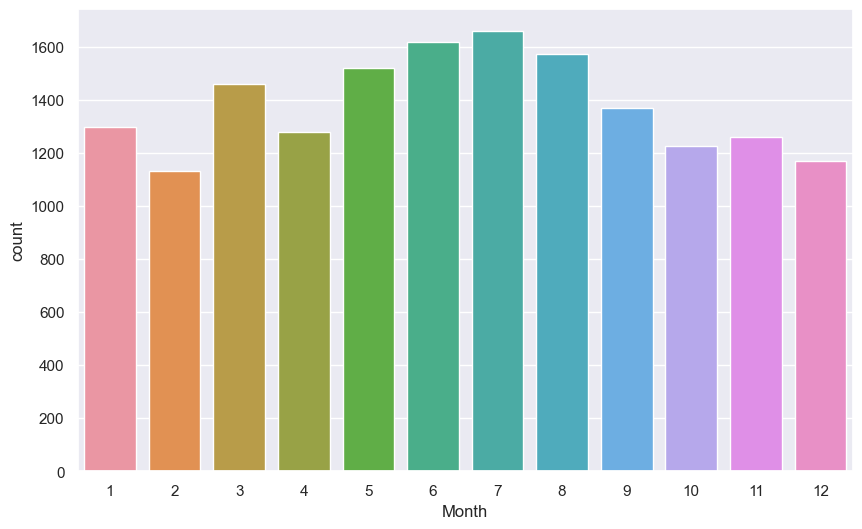

In [5]:
plt.figure(figsize=(10,6))
sns.countplot(data=df[df['RainTomorrow']=='Yes'],x='Month');

There are monts where the chances of raining increases, specially during summer

Location and Wind Directions are features that normaly have something to do with rains

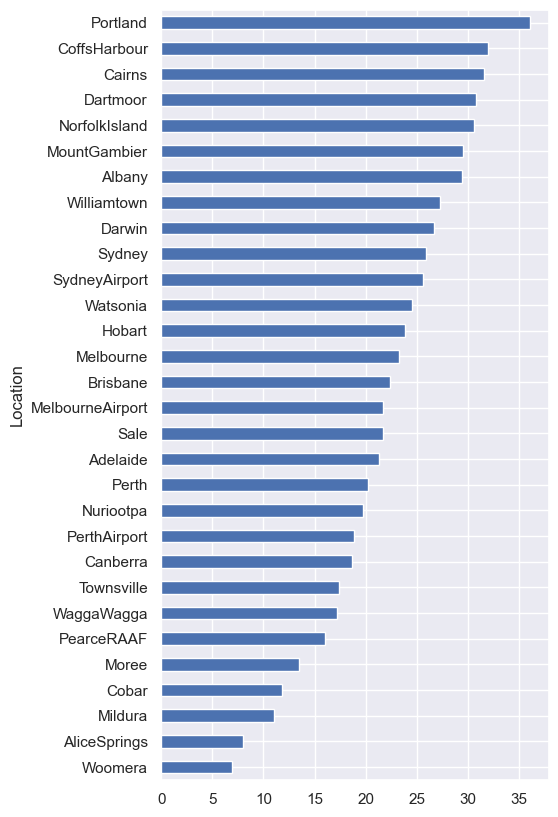

In [6]:
rainLoc_df=pd.crosstab(df['Location'],df['RainTomorrow']) 
# getting percentage of raining days and non raining days for each city 
rainLoc_df=rainLoc_df/rainLoc_df.transpose().sum().values.reshape((-1, 1))*100
rainLoc_sorted = rainLoc_df.sort_values(by='Yes',ascending=True )
rainLoc_sorted.Yes.plot(kind="barh",figsize=(5,10));

In [7]:
windgust_df=pd.crosstab(df['WindGustDir'],df['RainTomorrow']) 
windgust_df=windgust_df/windgust_df.transpose().sum().values.reshape((-1, 1))*100
windgust_df = windgust_df.sort_values(by='Yes',ascending=True )

In [8]:
winddir9am_df=pd.crosstab(df['WindDir9am'],df['RainTomorrow']) 
winddir9am_df=winddir9am_df/winddir9am_df.transpose().sum().values.reshape((-1, 1))*100
winddir9am_df = winddir9am_df.sort_values(by='Yes',ascending=True )

In [9]:
winddir3pm_df=pd.crosstab(df['WindDir3pm'],df['RainTomorrow']) 
winddir3pm_df=winddir3pm_df/winddir3pm_df.transpose().sum().values.reshape((-1, 1))*100
winddir3pm_df = winddir3pm_df.sort_values(by='Yes',ascending=True )

<AxesSubplot:>

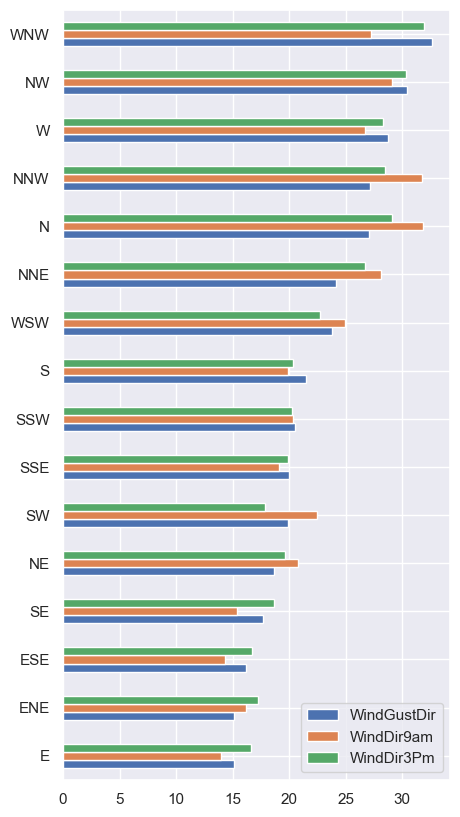

In [10]:
windDirs = pd.concat([windgust_df.Yes, winddir9am_df.Yes, winddir3pm_df.Yes], axis=1)
windDirs.columns = ['WindGustDir','WindDir9am','WindDir3Pm']
windDirs.plot(kind="barh",figsize=(5,10))

In [11]:
location_label_maping={}
for n, location in enumerate(rainLoc_sorted.index):
    location_label_maping[location] = n
df['Location'] = df['Location'].map(location_label_maping) 


windir_label_maping={}
for n, windir in enumerate(windDirs.index):
    windir_label_maping[windir] = n
df['WindGustDir'] = df['WindGustDir'].map(windir_label_maping)  
df['WindDir9am'] = df['WindDir9am'].map(windir_label_maping)  
df['WindDir3pm'] = df['WindDir3pm'].map(windir_label_maping)  

df['RainToday'] = df['RainToday'].map({'No':0, 'Yes':1})  

In [12]:
categorical = ['WindGustDir','WindDir9am','WindDir3pm','Location','RainToday']
df_labeled =  df.drop(['Date'],axis=1)
df_labeled.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'Month', 'RainTomorrow'],
      dtype='object')

### Handling Outliers 

In [13]:
def box_plot(dataf_outliers, df_no_outliers):
    plt.figure(figsize=(10,4))
    fig, axes = plt.subplots(1, 2, figsize=(11, 5))
    sns.boxplot(data=dataf_outliers.values, palette='pastel', ax = axes[0])
    axes[0].set_title(f'Box Plot: {dataf_outliers.name} - With Outliers')
    sns.boxplot(data=df_no_outliers.values, palette='pastel', ax = axes[1])
    axes[1].set_title(f'Box Plot: {df_no_outliers.name} - Without Outliers')  
    plt.show()


def drop_outliers(dataf, colname):
    dfcol = dataf[colname]
    dfcol = dfcol[~np.isnan(dfcol)]
    iqr = 1.5*(np.percentile(dfcol,75)-np.percentile(dfcol,25))
    
    dataf.drop(dataf[dataf[colname] > (iqr + np.percentile(dfcol,75))].index, inplace=True)
    dataf.drop(dataf[dataf[colname] < (np.percentile(dfcol,25)-iqr)].index, inplace=True)
    return dataf[colname]

outliers: (73905,), no outliers: (73967,)


<Figure size 1000x400 with 0 Axes>

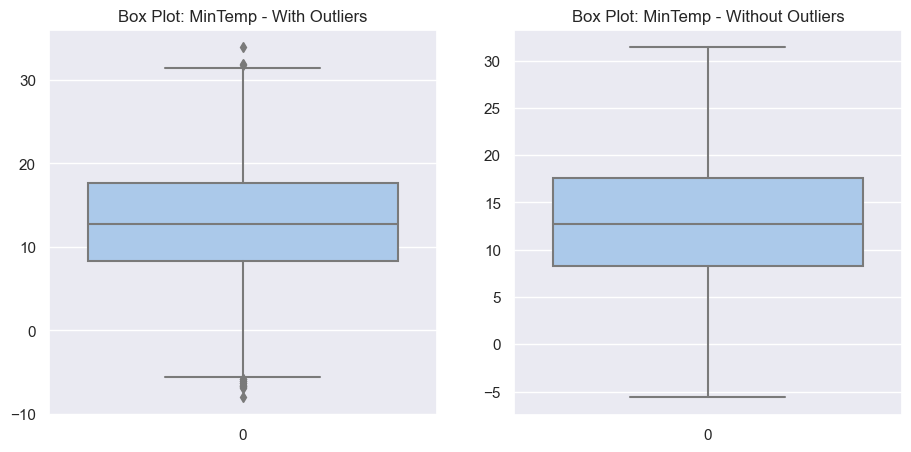

outliers: (73923,), no outliers: (73945,)


<Figure size 1000x400 with 0 Axes>

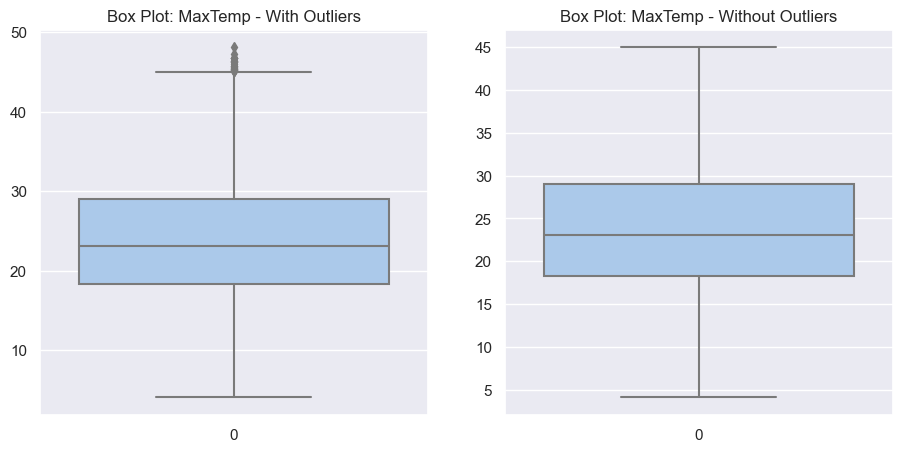

outliers: (73945,), no outliers: (60602,)


<Figure size 1000x400 with 0 Axes>

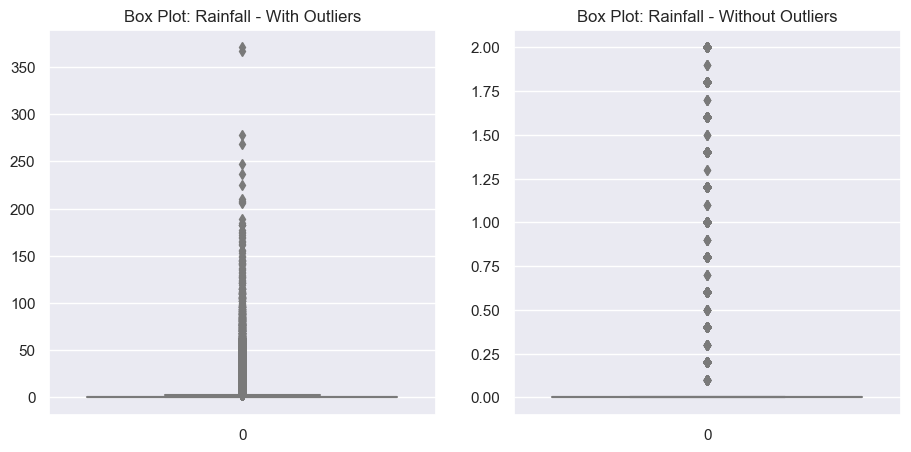

outliers: (57642,), no outliers: (59349,)


<Figure size 1000x400 with 0 Axes>

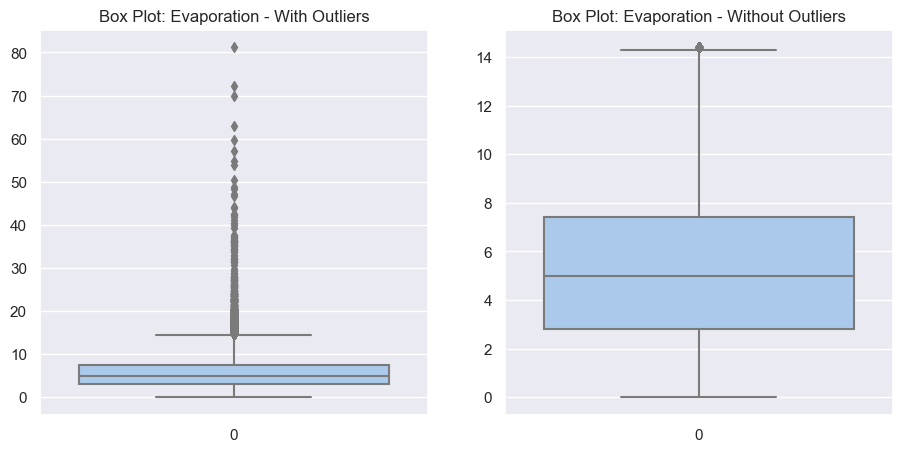

outliers: (59349,), no outliers: (59349,)


<Figure size 1000x400 with 0 Axes>

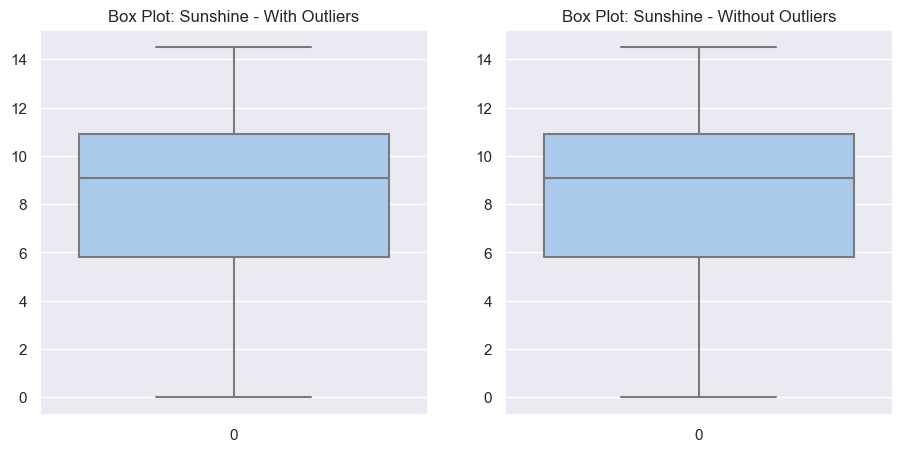

outliers: (56008,), no outliers: (57448,)


<Figure size 1000x400 with 0 Axes>

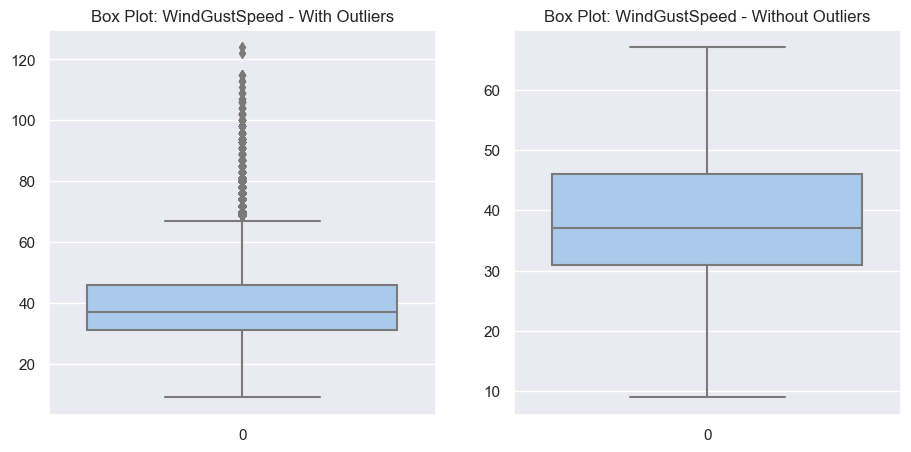

outliers: (57334,), no outliers: (56737,)


<Figure size 1000x400 with 0 Axes>

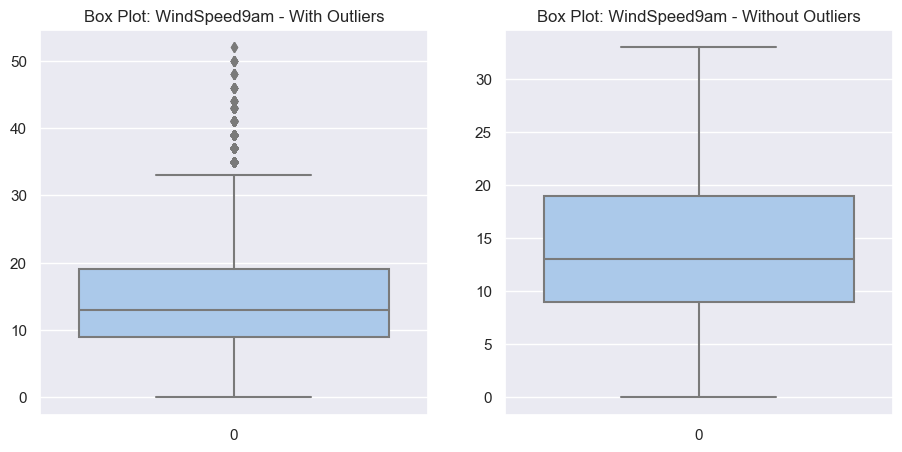

outliers: (56449,), no outliers: (56453,)


<Figure size 1000x400 with 0 Axes>

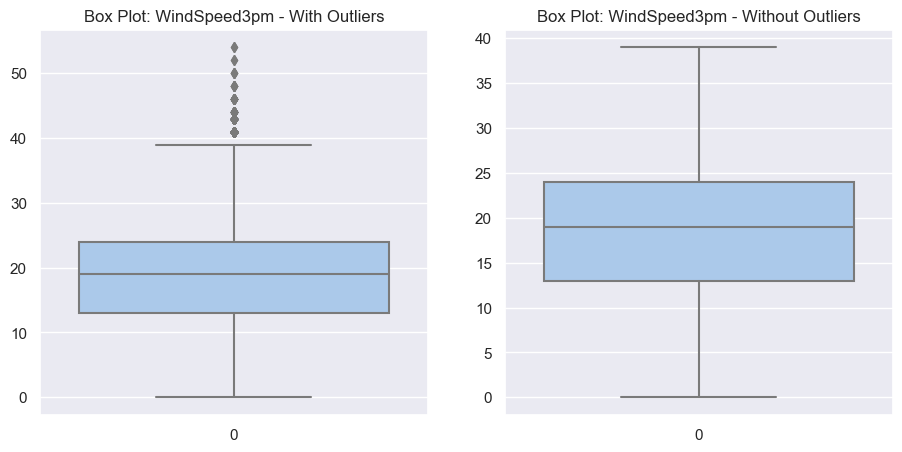

outliers: (56175,), no outliers: (55651,)


<Figure size 1000x400 with 0 Axes>

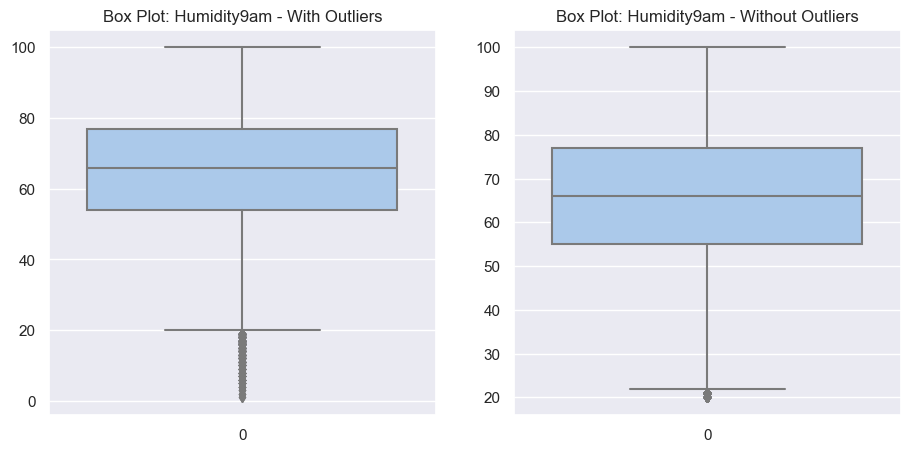

outliers: (55230,), no outliers: (55651,)


<Figure size 1000x400 with 0 Axes>

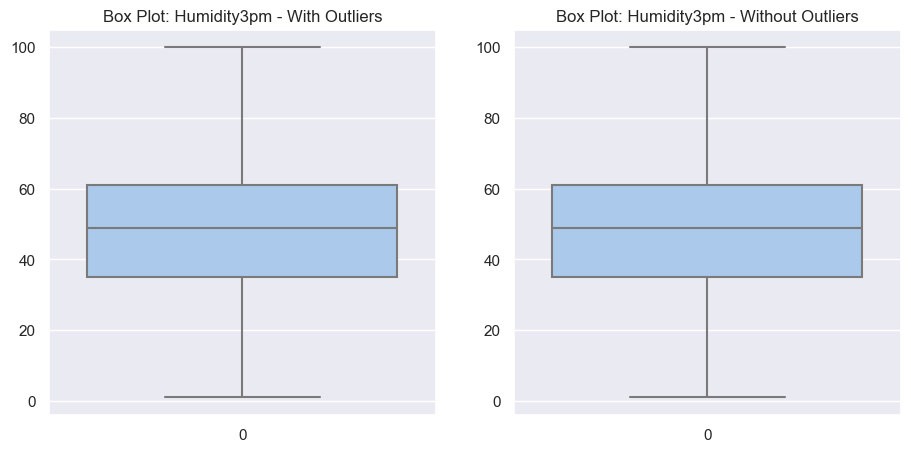

outliers: (55564,), no outliers: (55257,)


<Figure size 1000x400 with 0 Axes>

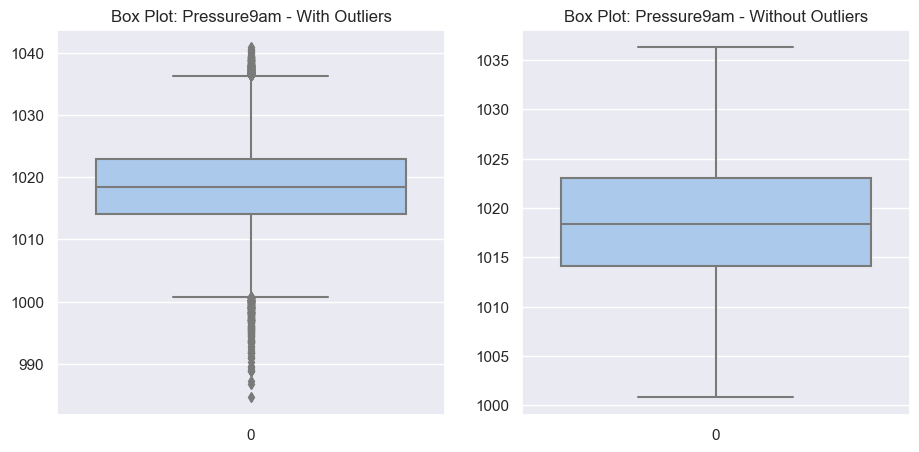

outliers: (55168,), no outliers: (55137,)


<Figure size 1000x400 with 0 Axes>

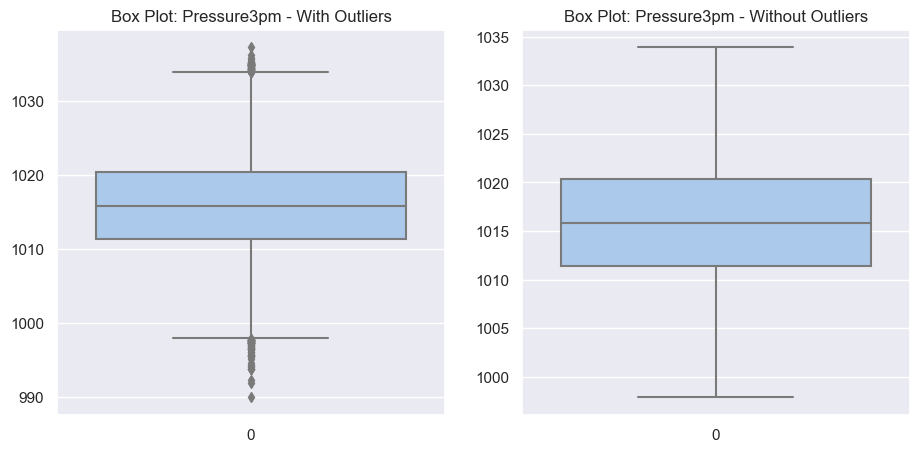

outliers: (49393,), no outliers: (55137,)


<Figure size 1000x400 with 0 Axes>

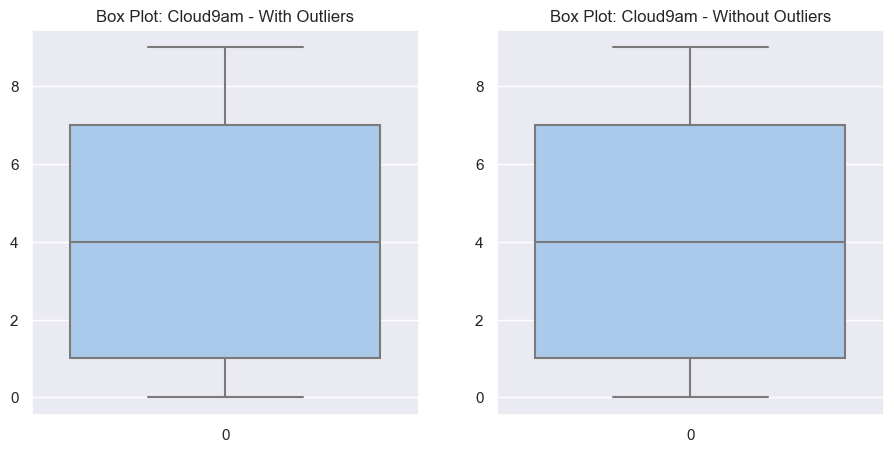

outliers: (48148,), no outliers: (55137,)


<Figure size 1000x400 with 0 Axes>

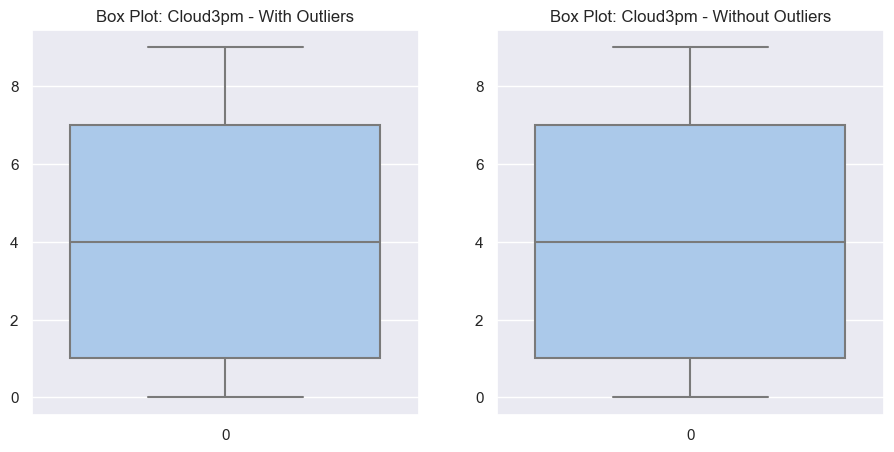

outliers: (55061,), no outliers: (55135,)


<Figure size 1000x400 with 0 Axes>

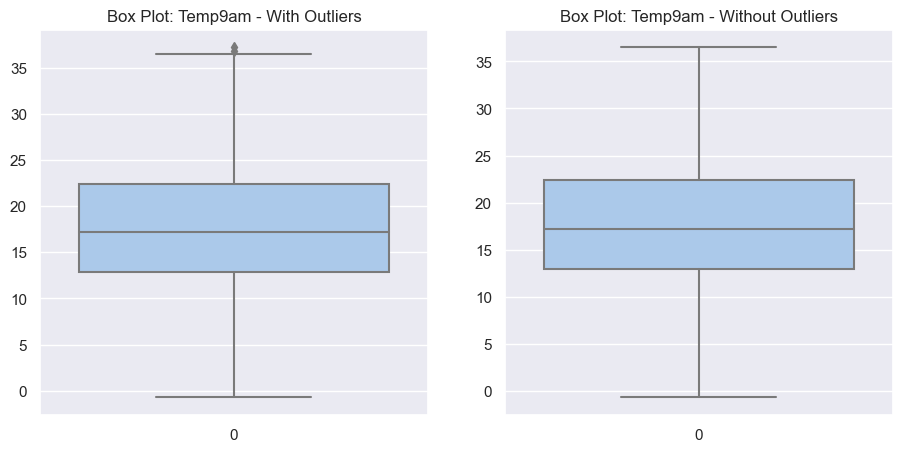

outliers: (54892,), no outliers: (55104,)


<Figure size 1000x400 with 0 Axes>

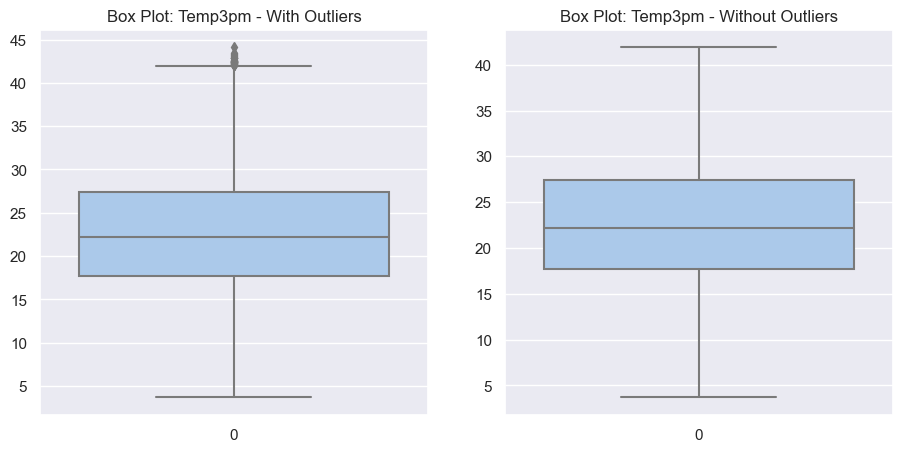

outliers: (55104,), no outliers: (55104,)


<Figure size 1000x400 with 0 Axes>

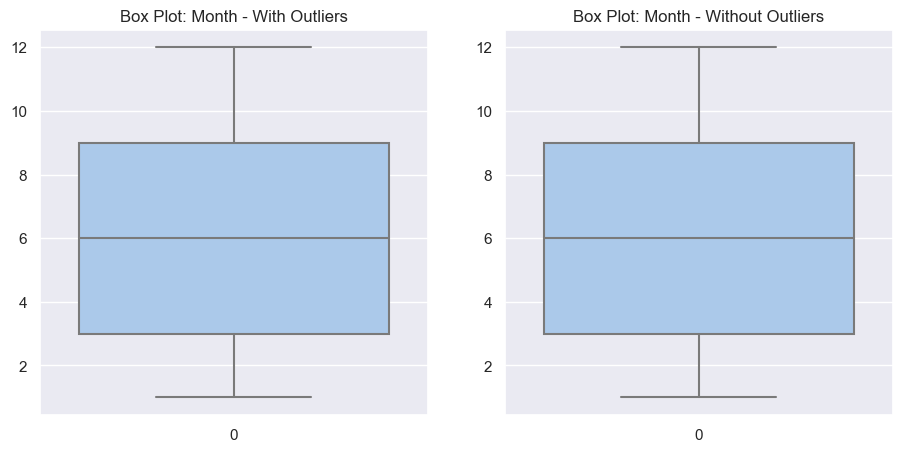

In [14]:
for col in df_labeled.columns:
    if col not in categorical + ['RainTomorrow']:
        dfcol = df_labeled[col]
        dfcol = dfcol[~np.isnan(dfcol)]
        df_no_outliers = drop_outliers(df_labeled, col)
        print(f'outliers: {dfcol.shape}, no outliers: {df_no_outliers.shape}')
        box_plot(dfcol, df_no_outliers)

### Handling Missing Values

In [15]:
def fill_mean(datacol):
    dataunique = datacol.unique()
    dataunique = dataunique[~np.isnan(dataunique)]
    data_mean = np.mean(dataunique)
    return datacol.fillna(data_mean)

In [16]:
for col in df_labeled.columns:
    if col not in ['RainTomorrow']:
        df_labeled[col] = fill_mean(df_labeled[col])

In [17]:
df_labeled.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Month            0
RainTomorrow     0
dtype: int64

In [18]:
df_labeled['RainTomorrow'] = df_labeled['RainTomorrow'].map({'No':0, 'Yes':1})  
X = df_labeled.drop('RainTomorrow',axis=1)
y = df_labeled['RainTomorrow']
X.shape

(55104, 22)

In [19]:
df_labeled0 = df_labeled.groupby('RainTomorrow', group_keys=False).apply(lambda x: x.sample(frac=0.1))
X = df_labeled0.drop('RainTomorrow',axis=1)
y = df_labeled0['RainTomorrow']
df_labeled0.head()

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
72745          2      6.0     19.6       0.0     4.600000       6.3   
89168         27     11.2     24.9       0.0     6.000000      10.9   
114978         5     13.9     35.5       0.0     6.922464      10.4   
45811          8      7.3     16.4       0.2     1.200000       8.5   
38841          6      2.2     13.0       0.0     1.200000       6.2   

        WindGustDir  WindGustSpeed  WindDir9am  WindDir3pm  ...  Humidity3pm  \
72745           9.0           37.0        13.0         9.0  ...         69.0   
89168           0.0           33.0         8.0         2.0  ...         42.0   
114978          7.0           35.0         0.0         2.0  ...         12.0   
45811          14.0           43.0        11.0        15.0  ...         48.0   
38841          12.0           30.0         0.0        14.0  ...         56.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
72745        1024.9       1022.8       8.0       4.0     12.4     17.4   
89168        1020.1       1016.9       2.0       3.0     20.4     23.3   
114978       1016.0       1012.2       4.5       4.5     25.6     33.9   
45811        1023.7       1019.7       1.0       1.0     11.2     14.7   
38841        1026.3       1021.6       1.0       7.0      6.6     12.3   

        RainToday  Month  RainTomorrow  
72745           0      9             0  
89168           0      7             0  
114978          0     12             0  
45811           0      6             0  
38841           0      7             0  

[5 rows x 23 columns]

In [20]:
mayority_weight = y.value_counts()[0]/y.shape[0]
minority_weight = y.value_counts()[1]/y.shape[0]
print(mayority_weight, minority_weight)

0.8446460980036298 0.15535390199637023


### Unbalance problems

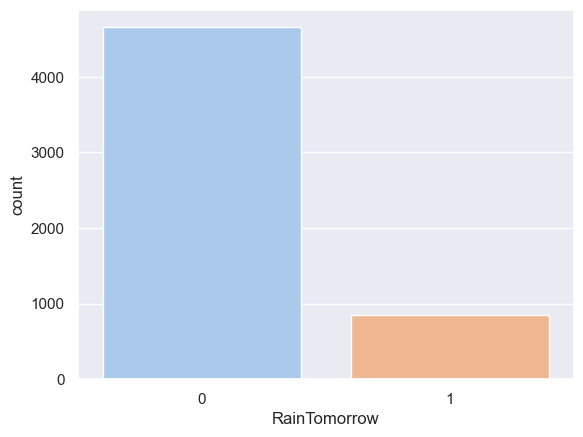

In [21]:
ax = sns.countplot(x=y, palette='pastel')

## Functions

In [22]:
def store_metrics(metr, ytest, ypr):
    metr[0].append(roc_auc_score(ytest, ypr))
    metr[1].append(f1_score(ytest, ypr))
    metr[2].append(precision_score(ytest, ypr))
    metr[3].append(recall_score(ytest, ypr))
    return metr

In [23]:
def calculate_KNN(Xtrain_resampled,Xtrain,ytrain_resampled,ytrain,Xtest,ytest, neighbors = 30):
    aucscores_resampled = []
    aucscores = []
    
    for k in range(1,neighbors):
        knn = KNeighborsClassifier(n_neighbors = k, weights='distance')
        knn.fit(Xtrain_resampled, ytrain_resampled)
        ypred_resampled = knn.predict(Xtest) 
        ## computing f1 score
        score = roc_auc_score(ytest, ypred_resampled)
        aucscores_resampled.append(score)
        
        knn = KNeighborsClassifier(n_neighbors = k,weights='distance')
        knn.fit(Xtrain, ytrain)
        ypred = knn.predict(Xtest) 
        ## computing f1 score
        score = roc_auc_score(ytest, ypred)
        aucscores.append(score)


    fig, axes = plt.subplots(1, 2, figsize=(11, 5))
    sns.set(font_scale = 1)
    sns.lineplot(y=aucscores_resampled, x=range(1,neighbors), ax = axes[0])
    axes[0].set_title('Balanced Dataset')
    axes[0].set(xlabel='Neighbors', ylabel='ROC-AUC Score')
    sns.lineplot(y=aucscores, x=range(1,neighbors), ax = axes[1])
    axes[1].set_title('Unbalanced Dataset')
    axes[1].set(xlabel='Neighbors', ylabel='ROC-AUC Score')
    
    return np.where(aucscores==np.max(aucscores))[0][0]+1,np.where(aucscores_resampled==np.max(aucscores_resampled))[0][0] +1


# FEATURE SUBSET SELECTION: MULTIVARIATE WRAPPER

In [67]:
df_labeled0.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'Month', 'RainTomorrow'],
      dtype='object')

In [68]:
df_labeled0

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
106527         0     10.8     22.4       0.0         11.0      10.3   
65387         14      8.2     16.5       0.2          3.2       6.0   
37673          6     14.8     28.0       0.0          6.4      11.0   
118261         9      8.8     27.2       0.0          5.4      11.1   
75762         29     12.0     17.8       0.2          3.4       7.7   
...          ...      ...      ...       ...          ...       ...   
22816         25     17.9     21.8       1.4          5.2       4.2   
21267         25     13.5     19.8       0.0          2.4       4.3   
63010         13     13.5     29.3       0.0          5.4       5.7   
87559         27     23.6     30.9       2.0          6.2       7.2   
36066         19     17.5     21.0       0.0          7.8       3.4   

        WindGustDir  WindGustSpeed  WindDir9am  WindDir3pm  ...  Humidity3pm  \
106527          8.0           46.0         3.0         7.0  ...         20.0   
65387           5.0           46.0        15.0         5.0  ...         53.0   
37673           0.0           37.0         0.0         4.0  ...         45.0   
118261          9.0           33.0         0.0         9.0  ...         45.0   
75762           7.0           46.0         3.0         6.0  ...         63.0   
...             ...            ...         ...         ...  ...          ...   
22816           0.0           52.0         2.0         2.0  ...         75.0   
21267           1.0           19.0         7.5         6.0  ...         61.0   
63010           6.0           44.0        11.0         8.0  ...         68.0   
87559           1.0           37.0         6.0         0.0  ...         63.0   
36066           7.0           52.0         7.0         6.0  ...         93.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
106527       1023.5       1019.9       0.0       4.5     14.7     21.4   
65387        1018.7       1017.7       5.0       5.0     12.3     14.7   
37673        1018.4       1013.1       1.0       1.0     18.4     27.2   
118261       1024.4       1019.9       0.0       0.0     18.5     25.0   
75762        1027.3       1026.9       8.0       7.0     14.3     16.9   
...             ...          ...       ...       ...      ...      ...   
22816        1009.3       1009.4       7.0       7.0     19.3     21.1   
21267        1018.8       1016.3       7.0       7.0     16.9     18.1   
63010        1012.9       1013.5       2.0       7.0     20.0     22.4   
87559        1013.5       1010.7       7.0       4.0     25.8     29.7   
36066        1017.5       1016.8       7.0       8.0     18.2     17.8   

        RainToday  Month  RainTomorrow  
106527          0      9             0  
65387           0      5             0  
37673           0      3             0  
118261          0      9             0  
75762           0      2             0  
...           ...    ...           ...  
22816           1     11             1  
21267           0      5             1  
63010           0      4             1  
87559           1     11             1  
36066           0      3             1  

[5510 rows x 23 columns]

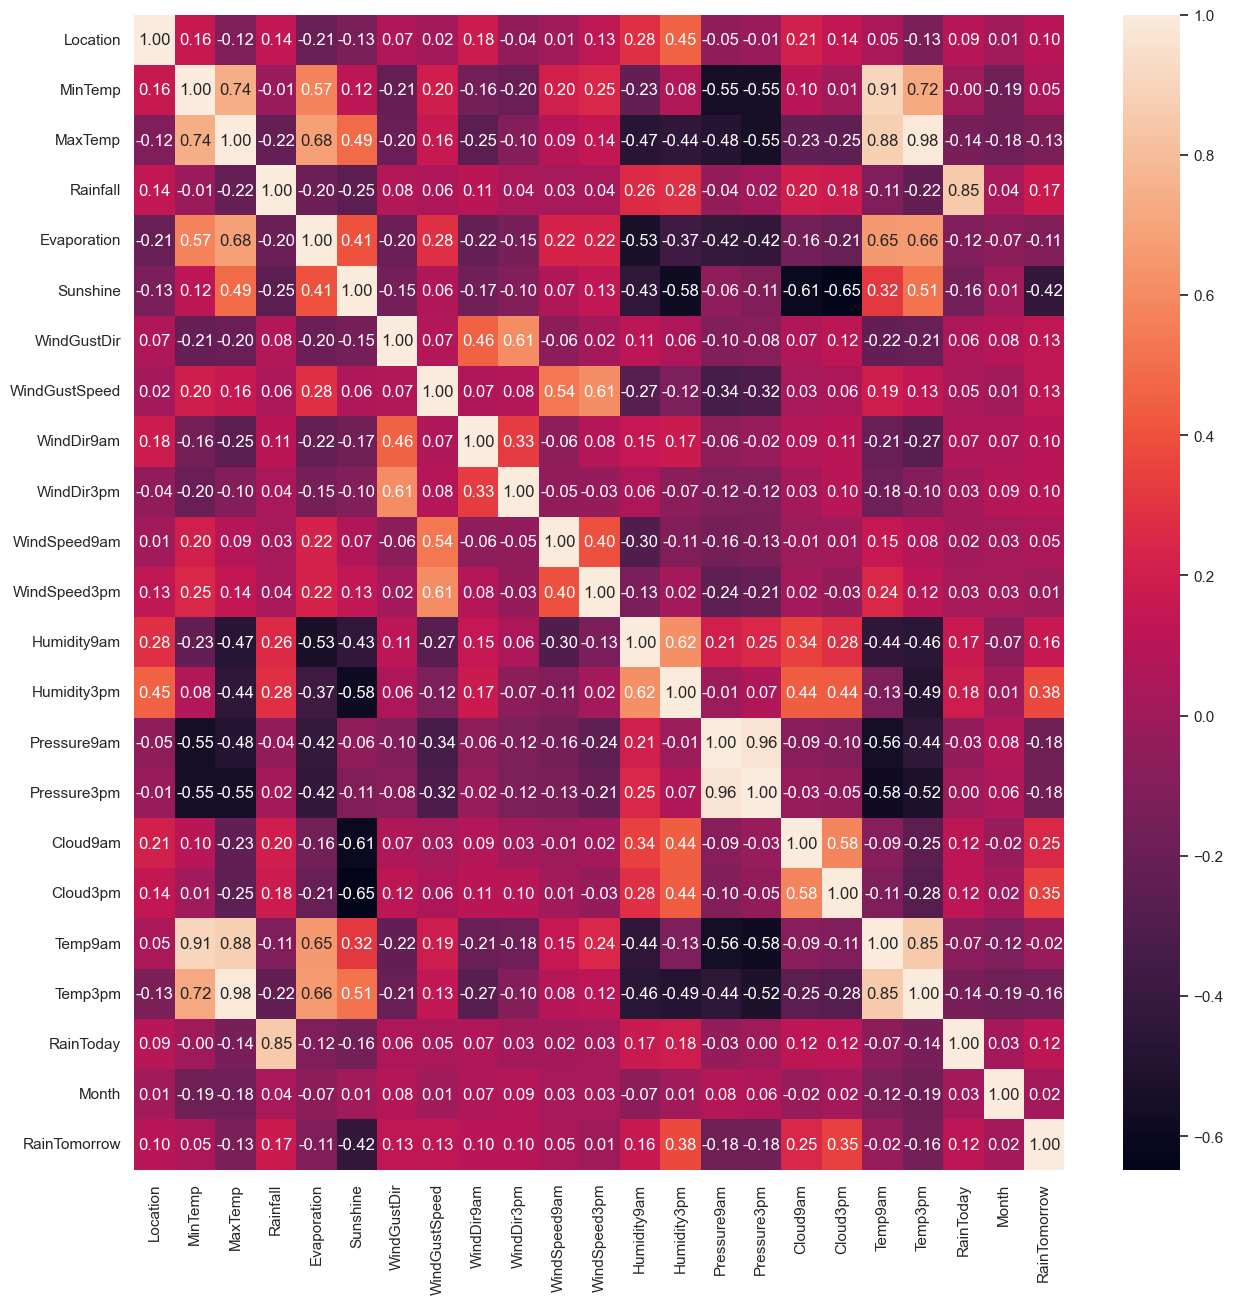

In [69]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(df_labeled0.corr(), annot=True, fmt='.2f') 
plt.show()



# KNN

### SMOTE Oversampling

In [25]:

smote = SMOTE()
stscaler = StandardScaler()
#normalization
Xnorm = stscaler.fit_transform(X)
Xnorm = pd.DataFrame(Xnorm, columns=X.columns)
Xnorm.head()

Location   MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustDir  \
0 -1.500203 -1.045596 -0.691998 -0.402945    -0.231272 -0.513102     0.467309   
1  1.487796 -0.230252  0.118126 -0.402945     0.239521  0.764688    -1.545008   
2 -1.141643  0.193100  1.738374 -0.402945     0.549729  0.625798     0.020127   
3 -0.783084 -0.841760 -1.181130  0.103205    -1.374628  0.098015     1.585262   
4 -1.022124 -1.641424 -1.700832 -0.402945    -1.374628 -0.540880     1.138081   

   WindGustSpeed  WindDir9am  WindDir3pm  ...  Humidity9am  Humidity3pm  \
0      -0.066277    1.324720    0.448873  ...     0.682764     1.139627   
1      -0.462565    0.229450   -1.082102  ...    -0.934155    -0.325374   
2      -0.264421   -1.522982   -1.082102  ...    -2.071987    -1.953152   
3       0.528155    0.886612    1.761137  ...     1.221738     0.000182   
4      -0.759782   -1.522982    1.542426  ...     0.982194     0.434256   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm   Temp9am   Temp3pm  \
0     1.022324     1.103138  1.505717 -0.039147 -0.835901 -0.833125   
1     0.255415     0.166745 -0.753832 -0.439708  0.427040  0.093308   
2    -0.399654    -0.579196  0.187646  0.161133  1.247951  1.757746   
3     0.830596     0.611135 -1.130424 -1.240830 -1.025342 -1.257086   
4     1.246006     0.912685 -1.130424  1.162535 -1.751533 -1.633940   

   RainToday     Month  
0  -0.243745  0.789099  
1  -0.243745  0.203715  
2  -0.243745  1.667173  
3  -0.243745 -0.088976  
4  -0.243745  0.203715  

[5 rows x 22 columns]

In [26]:
knn = KNeighborsClassifier(weights='distance')
sfs = SFS(knn, n_features_to_select='auto', scoring='roc_auc', direction="forward", n_jobs=-1)
sfs.fit(Xnorm, y)
features= pd.DataFrame(sfs.get_feature_names_out(), columns=['Features'])
Xnorm_new = sfs.transform(Xnorm)
Xnorm_new = pd.DataFrame(Xnorm_new, columns = features.Features)

In [27]:
features

Features
0       Location
1        MaxTemp
2       Sunshine
3     WindDir9am
4   WindSpeed3pm
5    Humidity3pm
6    Pressure9am
7    Pressure3pm
8        Temp9am
9        Temp3pm
10     RainToday

In [28]:
#split into train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(Xnorm_new, y, test_size=0.2, random_state=13)
Xtrain_resampled, ytrain_resampled = smote.fit_resample(Xtrain, ytrain)
Xtrain.head()

Features  Location   MaxTemp  Sunshine  WindDir9am  WindSpeed3pm  Humidity3pm  \
1039     -0.424524 -0.493288  0.014681   -1.303928     -1.508558    -0.216855   
2443     -0.663564  0.775397  1.431361   -1.522982     -0.702744    -1.519078   
2434      1.368276  1.142245  1.431361   -0.865820     -0.165535    -0.596670   
127       0.651156  1.386811 -0.040876    1.324720      0.103070    -1.573337   
3420      0.053556  1.096389  1.014690   -0.427712     -0.702744     0.814071   

Features  Pressure9am  Pressure3pm   Temp9am   Temp3pm  RainToday  
1039         1.086233     1.039654 -0.930621 -0.314951  -0.243745  
2443         0.207483    -0.007837  0.348106  0.956931  -0.243745  
2434        -1.454154    -1.293395  0.553334  1.255274  -0.243745  
127         -1.725767    -1.626687  0.758562  1.506510  -0.243745  
3420        -0.815063    -0.991844  1.295311  0.878420  -0.243745

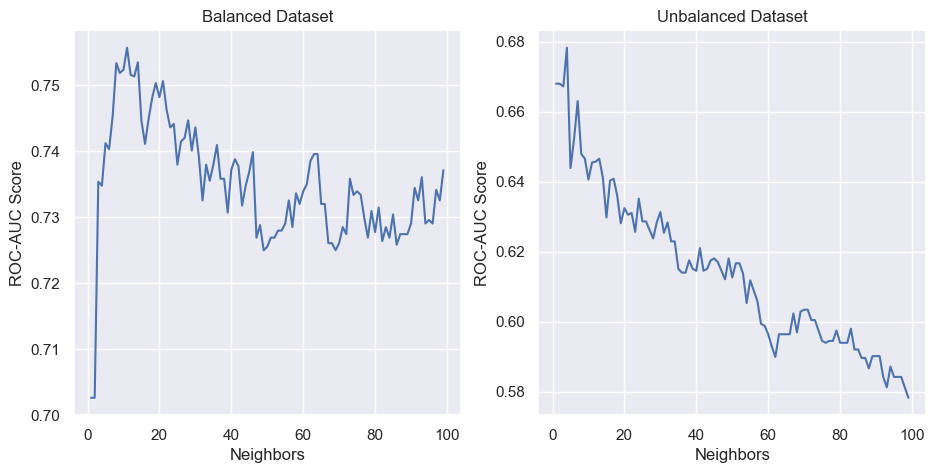

In [29]:
kmax, k_resampled_max = calculate_KNN(Xtrain_resampled,Xtrain,ytrain_resampled,ytrain,Xtest,ytest, neighbors = 100)

In [30]:
print(kmax, k_resampled_max)

4 11


In [148]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
metrics_resampled = [[],[],[],[]]
metrics = [[],[],[],[]]
results_resampled = []
results = []
Xtrain0 = np.array(Xnorm_new)
ytrain0 = np.array(y)
for train_ix, test_ix in kfold.split(Xtrain0, ytrain0):
    # select rows
    train_X, test_X = Xtrain0[train_ix], Xtrain0[test_ix]
    train_y, test_y = ytrain0[train_ix], ytrain0[test_ix]
    
    # train unbalanced
    knn_unbalanced = KNeighborsClassifier(n_neighbors = kmax, weights='distance')
    knn_unbalanced.fit(train_X, train_y)
    ypred = knn_unbalanced.predict(test_X)
    
    metrics = store_metrics(metrics, test_y, ypred)
    results.append([test_y, ypred])
    
    
    # train balanced 
    Xtrain_resampled0, ytrain_resampled0 = smote.fit_resample(train_X, train_y)
    knn_balanced = KNeighborsClassifier(n_neighbors = k_resampled_max, weights='distance')
    knn_balanced.fit(Xtrain_resampled0, ytrain_resampled0)
    ypred_resampled = knn_balanced.predict(test_X)
    
    metrics_resampled = store_metrics(metrics_resampled, test_y, ypred_resampled)
    results_resampled.append([test_y, ypred_resampled])

In [149]:
metrics_resampled = np.array(metrics_resampled)
metrics = np.array(metrics)
results_resampled = np.array(results_resampled)
results = np.array(results)

columns_resampled = ['ROC_AUC_resampled','F1_resampled','Precision_resampled','Recall_resampled']
columns = ['ROC_AUC','F1','Precision','Recall']
metrics_scores = pd.DataFrame(np.concatenate([metrics_resampled.T, metrics.T],axis=1), columns = columns_resampled + columns)
mean_score = np.mean(np.array(metrics_scores), axis=0)
mean_score0 = pd.DataFrame(mean_score.round(3).reshape(2,4), columns = columns, index=['Balanced','Unbalanced'])
mean_score0

ROC_AUC     F1  Precision  Recall
Balanced      0.709  0.456      0.360   0.620
Unbalanced    0.659  0.445      0.555   0.373

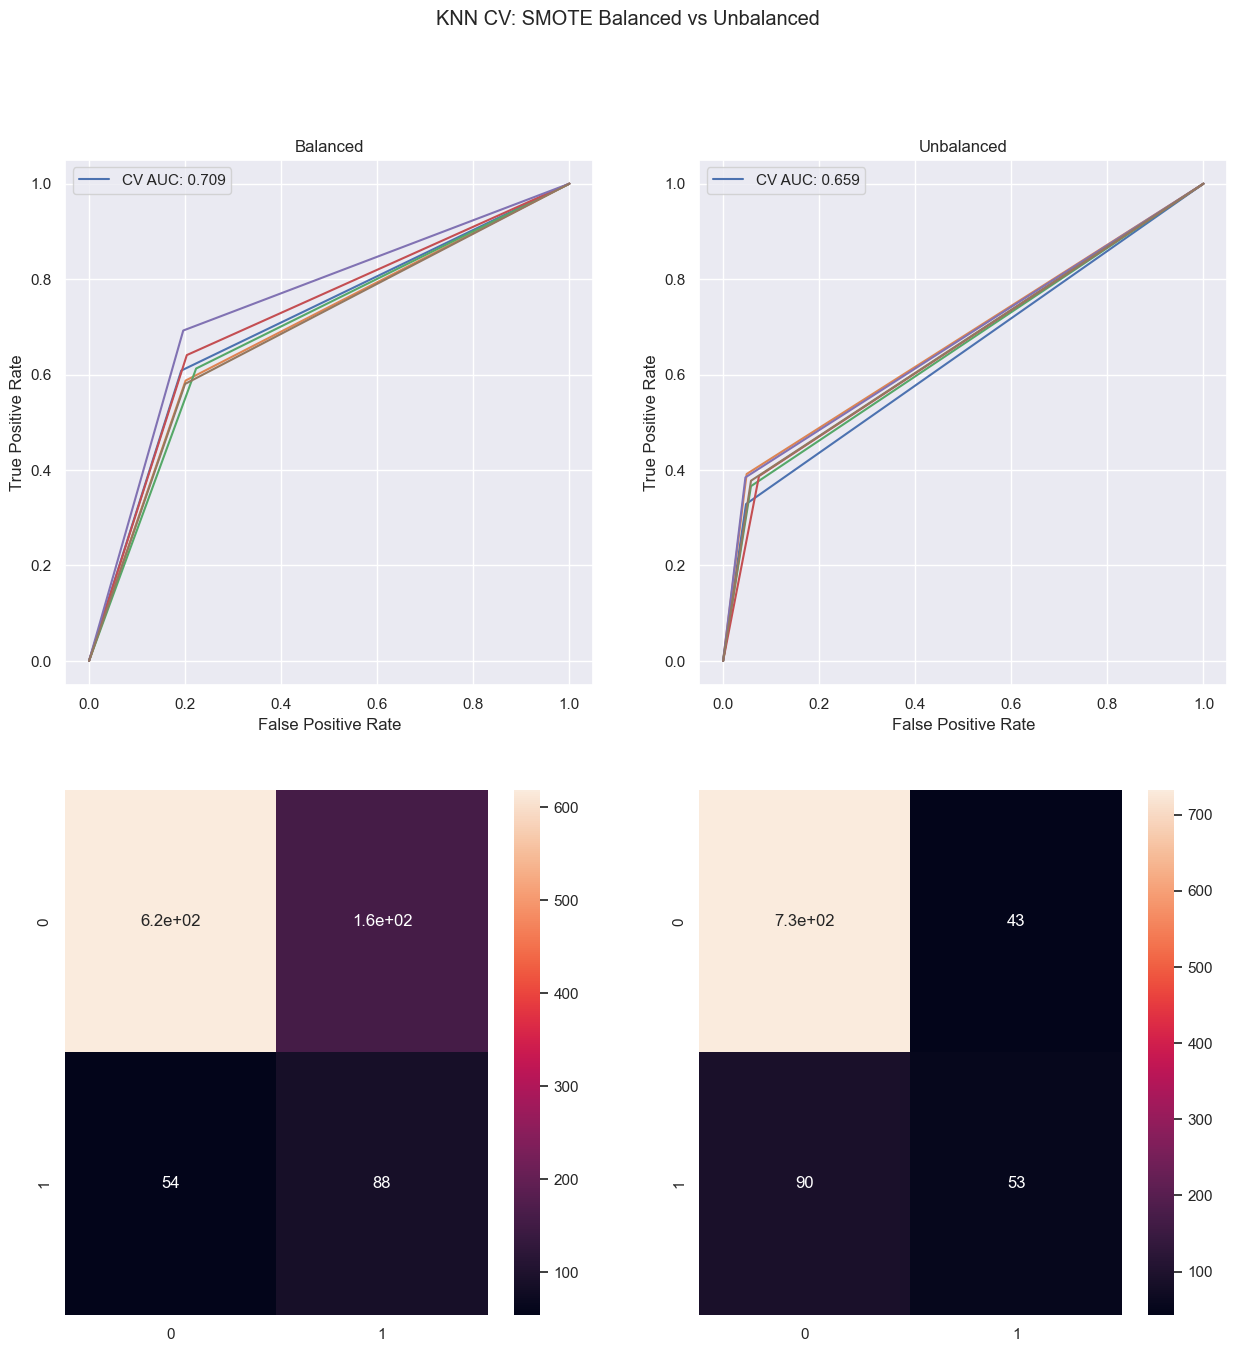

In [150]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle(f'KNN CV: SMOTE Balanced vs Unbalanced')
sns.set(font_scale = 1)

cflist = []
cflist_resampled = []
for res_resampled, res in zip(results_resampled, results):

    fpr, tpr, _ = roc_curve(res_resampled[0],  res_resampled[1])
    auc = roc_auc_score(res_resampled[0],  res_resampled[1])
    cf = confusion_matrix(res_resampled[0],  res_resampled[1])
    cflist_resampled.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,0])
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].set_title('Balanced')

    
    
    fpr, tpr, _ = roc_curve(res[0],  res[1])
    auc = roc_auc_score(res[0],  res[1])
    cf = confusion_matrix(res[0],  res[1])
    cflist.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,1])
    axes[0,1].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,1].set_title('Unbalanced')
    
    
axes[0,0].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][0],3)}"])
axes[0,1].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][1],3)}"])

cf = np.mean(cflist,axis=0)
cf_resampled = np.mean(cflist_resampled,axis=0)
sns.heatmap(pd.DataFrame(cf_resampled) , annot=True, ax = axes[1,0])
sns.heatmap(pd.DataFrame(cf) , annot=True, ax = axes[1,1])   
plt.show()

    

### NearMiss Undersampling

In [34]:
from imblearn.under_sampling import NearMiss
nm = NearMiss()
#split into train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(Xnorm_new, y, test_size=0.2, random_state=13)
Xtrain_resampled, ytrain_resampled = nm.fit_resample(Xtrain, ytrain)

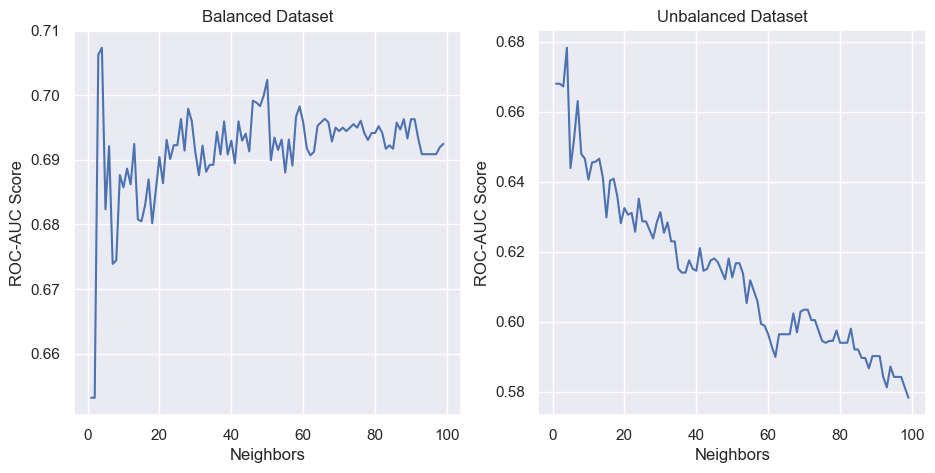

In [35]:
kmax, k_resampled_max = calculate_KNN(Xtrain_resampled,Xtrain,ytrain_resampled,ytrain,Xtest,ytest, neighbors = 100)

In [36]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
metrics_resampled = [[],[],[],[]]
metrics = [[],[],[],[]]
results_resampled = []
results = []
Xtrain0 = np.array(Xnorm_new)
ytrain0 = np.array(y)
for train_ix, test_ix in kfold.split(Xtrain0, ytrain0):
    # select rows
    train_X, test_X = Xtrain0[train_ix], Xtrain0[test_ix]
    train_y, test_y = ytrain0[train_ix], ytrain0[test_ix]
    
    # train unbalanced
    knn_unbalanced = KNeighborsClassifier(n_neighbors = kmax, weights='distance')
    knn_unbalanced.fit(train_X, train_y)
    ypred = knn_unbalanced.predict(test_X)
    
    metrics = store_metrics(metrics, test_y, ypred)
    results.append([test_y, ypred])
    
    
    # train balanced 
    Xtrain_resampled0, ytrain_resampled0 = nm.fit_resample(train_X, train_y)
    knn_balanced = KNeighborsClassifier(n_neighbors = k_resampled_max, weights='distance')
    knn_balanced.fit(Xtrain_resampled0, ytrain_resampled0)
    ypred_resampled = knn_balanced.predict(test_X)
    
    metrics_resampled = store_metrics(metrics_resampled, test_y, ypred_resampled)
    results_resampled.append([test_y, ypred_resampled])

In [37]:
metrics_resampled = np.array(metrics_resampled)
metrics = np.array(metrics)
results_resampled = np.array(results_resampled)
results = np.array(results)

columns_resampled = ['ROC_AUC_resampled','F1_resampled','Precision_resampled','Recall_resampled']
columns = ['ROC_AUC','F1','Precision','Recall']
metrics_scores = pd.DataFrame(np.concatenate([metrics_resampled.T, metrics.T],axis=1), columns = columns_resampled + columns)
mean_score = np.mean(np.array(metrics_scores), axis=0)
mean_score0 = pd.DataFrame(mean_score.round(3).reshape(2,4), columns = columns, index=['Balanced','Unbalanced'])
mean_score0

ROC_AUC    F1  Precision  Recall
Balanced      0.678  0.40      0.289   0.652
Unbalanced    0.647  0.42      0.518   0.354

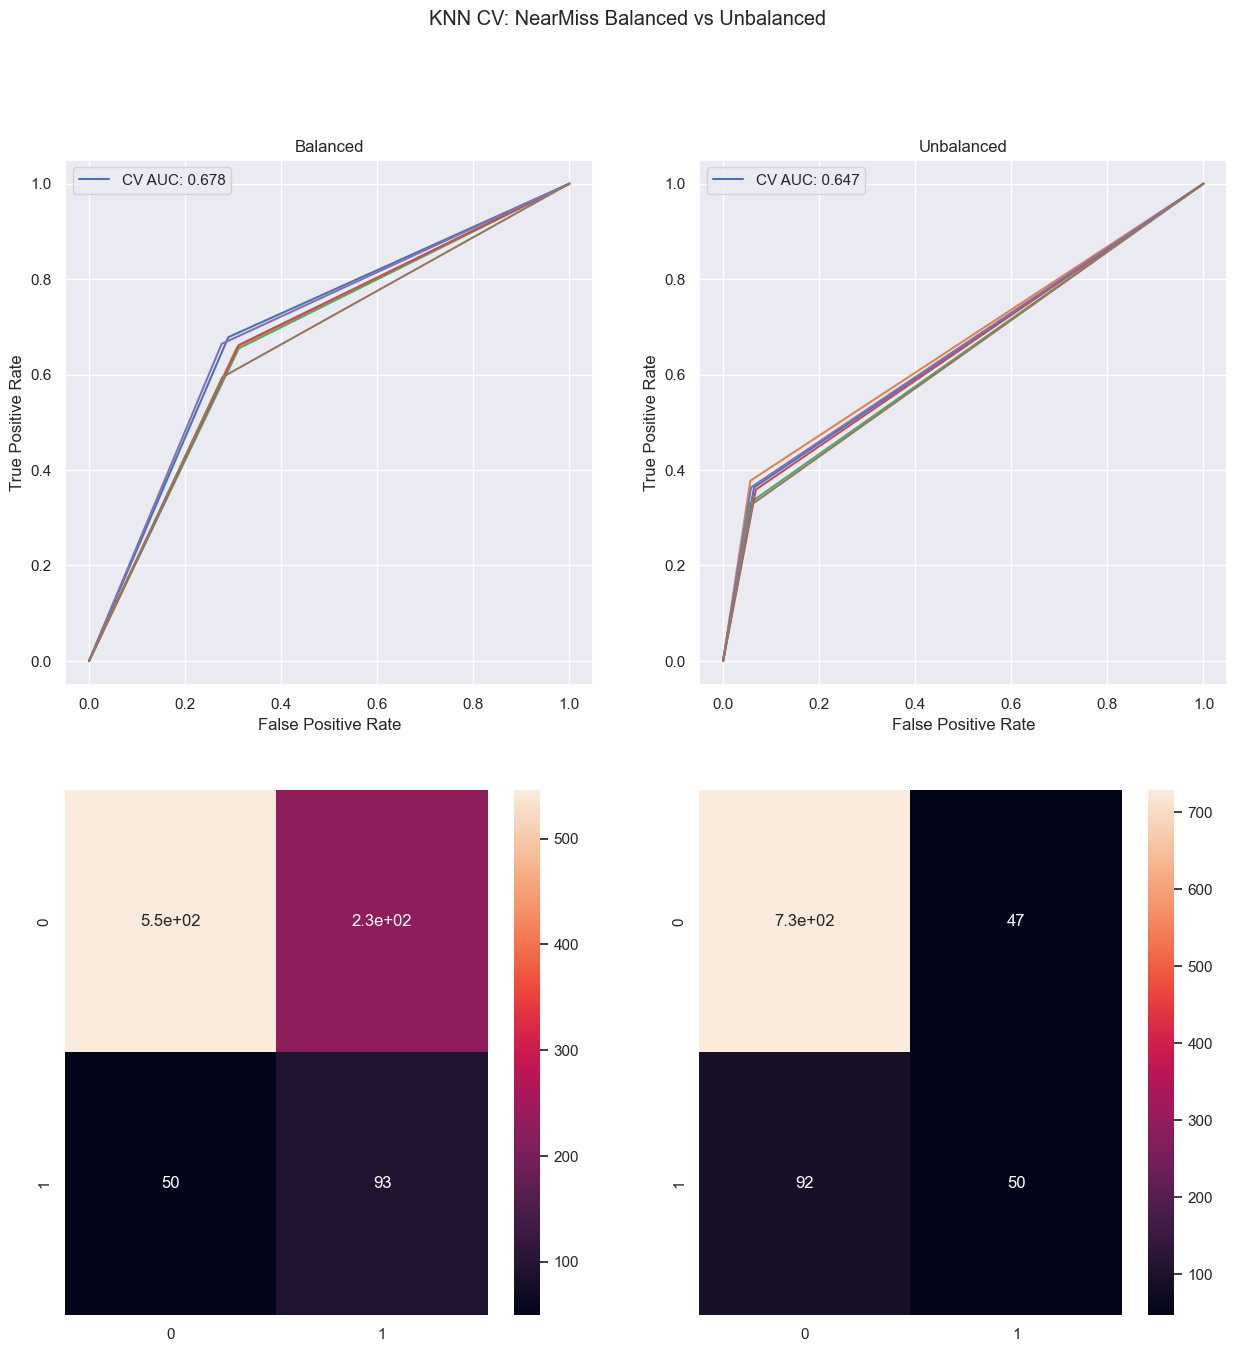

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle(f'KNN CV: NearMiss Balanced vs Unbalanced')
sns.set(font_scale = 1)

cflist = []
cflist_resampled = []
for res_resampled, res in zip(results_resampled, results):

    fpr, tpr, _ = roc_curve(res_resampled[0],  res_resampled[1])
    auc = roc_auc_score(res_resampled[0],  res_resampled[1])
    cf = confusion_matrix(res_resampled[0],  res_resampled[1])
    cflist_resampled.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,0])
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].set_title('Balanced')

    
    
    fpr, tpr, _ = roc_curve(res[0],  res[1])
    auc = roc_auc_score(res[0],  res[1])
    cf = confusion_matrix(res[0],  res[1])
    cflist.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,1])
    axes[0,1].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,1].set_title('Unbalanced')
    
    
axes[0,0].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][0],3)}"])
axes[0,1].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][1],3)}"])

cf = np.mean(cflist,axis=0)
cf_resampled = np.mean(cflist_resampled,axis=0)
sns.heatmap(pd.DataFrame(cf_resampled) , annot=True, ax = axes[1,0])
sns.heatmap(pd.DataFrame(cf) , annot=True, ax = axes[1,1])   
plt.show()

    

# SVM

### SMOTE Oversampling

In [39]:
svm = SVC(kernel='rbf', class_weight='balanced', gamma='auto', random_state=0)
sfs = SFS(svm, n_features_to_select='auto', scoring='roc_auc', direction="forward", n_jobs=-1)
sfs.fit(Xnorm, y)
features= pd.DataFrame(sfs.get_feature_names_out(), columns=['Features'])
Xnorm_new = sfs.transform(Xnorm)
Xnorm_new = pd.DataFrame(Xnorm_new, columns = features.Features)

In [40]:
features

Features
0        Location
1         MaxTemp
2        Sunshine
3   WindGustSpeed
4      WindDir3pm
5     Humidity3pm
6     Pressure9am
7     Pressure3pm
8         Temp9am
9         Temp3pm
10          Month

In [41]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
metrics_resampled = [[],[],[],[]]
metrics = [[],[],[],[]]
results_resampled = []
results = []
Xtrain0 = np.array(Xnorm_new)
ytrain0 = np.array(y)
for train_ix, test_ix in kfold.split(Xtrain0, ytrain0):
    # select rows
    train_X, test_X = Xtrain0[train_ix], Xtrain0[test_ix]
    train_y, test_y = ytrain0[train_ix], ytrain0[test_ix]
    
    # train unbalanced
    svm_unbalanced = SVC(kernel='rbf', class_weight = 'balanced', gamma=0.001, random_state=0)
    svm_unbalanced.fit(train_X, train_y)
    ypred = svm_unbalanced.predict(test_X)
    
    metrics = store_metrics(metrics, test_y, ypred)
    results.append([test_y, ypred])
    
    
    # train balanced 
    Xtrain_resampled0, ytrain_resampled0 = smote.fit_resample(train_X, train_y)
    svm_balanced = SVC(kernel='rbf', C = 0.03, gamma='auto', random_state=0)
    svm_balanced.fit(Xtrain_resampled0, ytrain_resampled0)
    ypred_resampled = svm_balanced.predict(test_X)
    
    metrics_resampled = store_metrics(metrics_resampled, test_y, ypred_resampled)
    results_resampled.append([test_y, ypred_resampled])
    
    
    



In [42]:
metrics_resampled = np.array(metrics_resampled)
metrics = np.array(metrics)
results_resampled = np.array(results_resampled)
results = np.array(results)

columns_resampled = ['ROC_AUC_resampled','F1_resampled','Precision_resampled','Recall_resampled']
columns = ['ROC_AUC','F1','Precision','Recall']
metrics_scores = pd.DataFrame(np.concatenate([metrics_resampled.T, metrics.T],axis=1), columns = columns_resampled + columns)
mean_score = np.mean(np.array(metrics_scores), axis=0)
mean_score0 = pd.DataFrame(mean_score.round(3).reshape(2,4), columns = columns, index=['Balanced','Unbalanced'])
mean_score0


ROC_AUC     F1  Precision  Recall
Balanced      0.767  0.513      0.391   0.750
Unbalanced    0.763  0.510      0.389   0.741

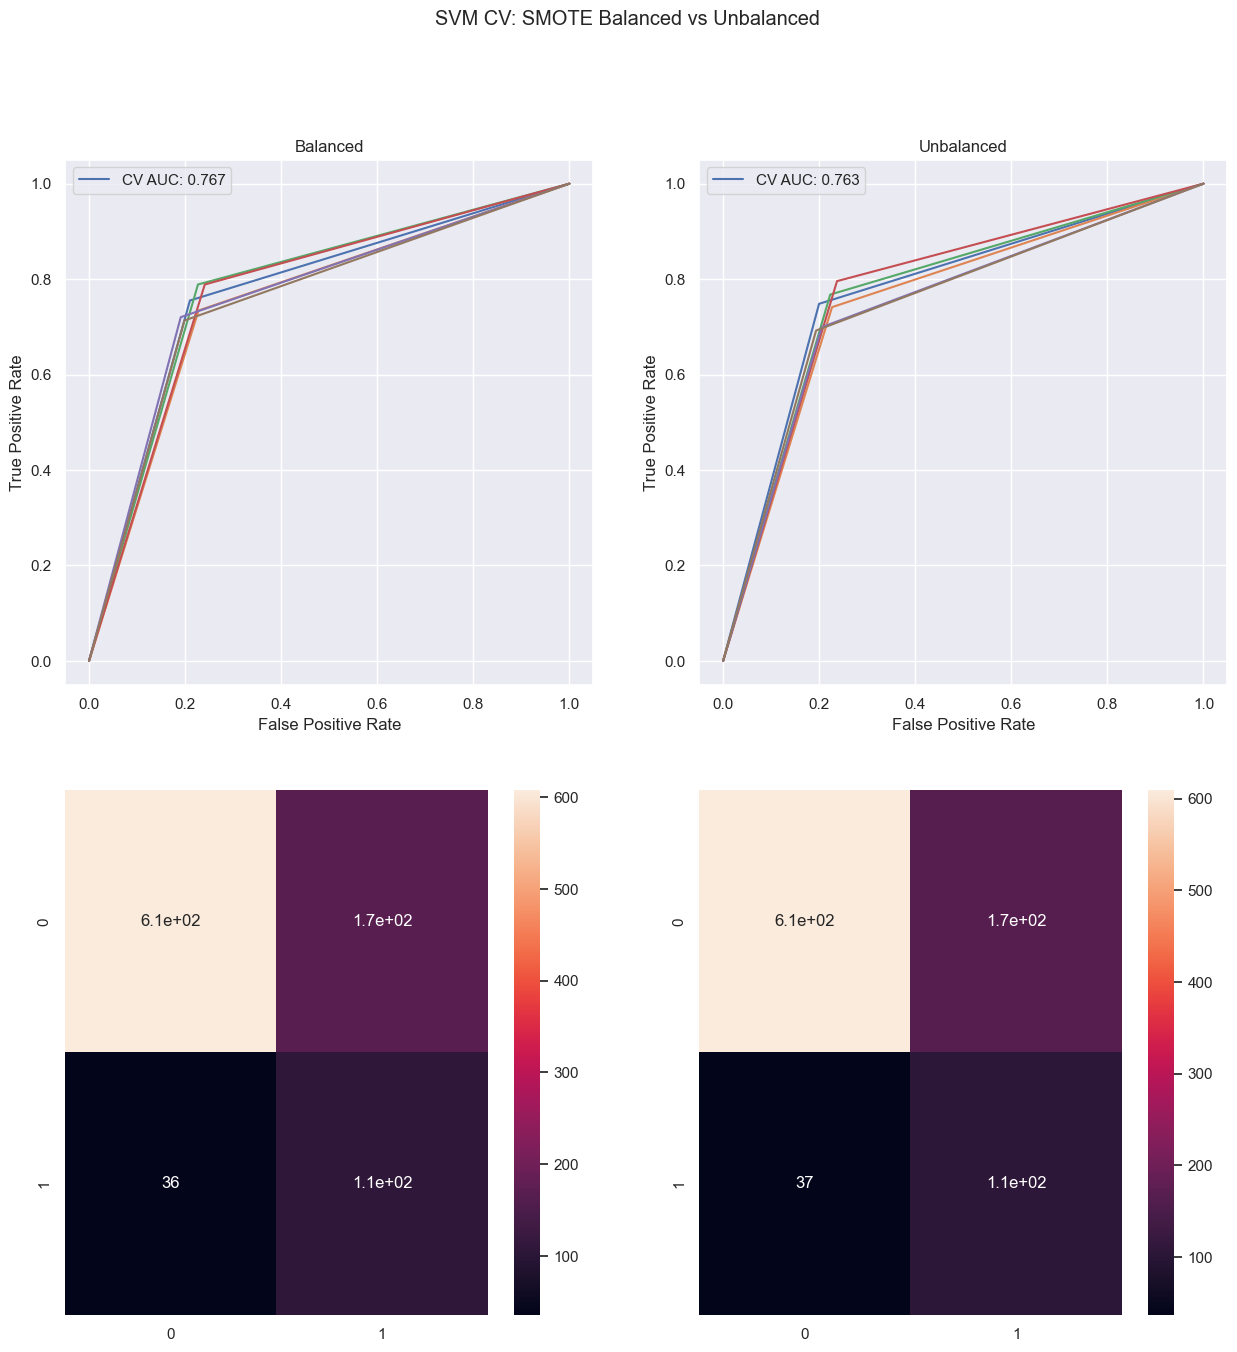

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle(f'SVM CV: SMOTE Balanced vs Unbalanced')
sns.set(font_scale = 1)

cflist = []
cflist_resampled = []
for res_resampled, res in zip(results_resampled, results):

    fpr, tpr, _ = roc_curve(res_resampled[0],  res_resampled[1])
    auc = roc_auc_score(res_resampled[0],  res_resampled[1])
    cf = confusion_matrix(res_resampled[0],  res_resampled[1])
    cflist_resampled.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,0])
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].set_title('Balanced')

    
    
    fpr, tpr, _ = roc_curve(res[0],  res[1])
    auc = roc_auc_score(res[0],  res[1])
    cf = confusion_matrix(res[0],  res[1])
    cflist.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,1])
    axes[0,1].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,1].set_title('Unbalanced')
    
    
axes[0,0].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][0],3)}"])
axes[0,1].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][1],3)}"])

cf = np.mean(cflist,axis=0)
cf_resampled = np.mean(cflist_resampled,axis=0)
sns.heatmap(pd.DataFrame(cf_resampled) , annot=True, ax = axes[1,0])
sns.heatmap(pd.DataFrame(cf) , annot=True, ax = axes[1,1])   
plt.show()
    
    

### NearMiss Undersampling

In [44]:
from imblearn.under_sampling import NearMiss
nm = NearMiss()


In [45]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
metrics_resampled = [[],[],[],[]]
metrics = [[],[],[],[]]
results_resampled = []
results = []
Xtrain0 = np.array(Xnorm_new)
ytrain0 = np.array(y)
for train_ix, test_ix in kfold.split(Xtrain0, ytrain0):
    # select rows
    train_X, test_X = Xtrain0[train_ix], Xtrain0[test_ix]
    train_y, test_y = ytrain0[train_ix], ytrain0[test_ix]
    
    # train unbalanced
    svm_unbalanced = SVC(kernel='rbf', class_weight = 'balanced', gamma=0.001)
    svm_unbalanced.fit(train_X, train_y)
    ypred = svm_unbalanced.predict(test_X)
    
    metrics = store_metrics(metrics, test_y, ypred)
    results.append([test_y, ypred])
    
    
    # train balanced 
    Xtrain_resampled0, ytrain_resampled0 = nm.fit_resample(train_X, train_y)
    svm_balanced = SVC(kernel='rbf', class_weight = 'balanced' , gamma=0.001)
    svm_balanced.fit(Xtrain_resampled0, ytrain_resampled0)
    ypred_resampled = svm_balanced.predict(test_X)
    
    metrics_resampled = store_metrics(metrics_resampled, test_y, ypred_resampled)
    results_resampled.append([test_y, ypred_resampled])
    
    
    



In [46]:
metrics_resampled = np.array(metrics_resampled)
metrics = np.array(metrics)
results_resampled = np.array(results_resampled)
results = np.array(results)

columns_resampled = ['ROC_AUC_resampled','F1_resampled','Precision_resampled','Recall_resampled']
columns = ['ROC_AUC','F1','Precision','Recall']
metrics_scores = pd.DataFrame(np.concatenate([metrics_resampled.T, metrics.T],axis=1), columns = columns_resampled + columns)
mean_score = np.mean(np.array(metrics_scores), axis=0)
mean_score0 = pd.DataFrame(mean_score.round(3).reshape(2,4), columns = columns, index=['Balanced','Unbalanced'])
mean_score0


ROC_AUC     F1  Precision  Recall
Balanced      0.737  0.505      0.419   0.636
Unbalanced    0.763  0.510      0.389   0.741

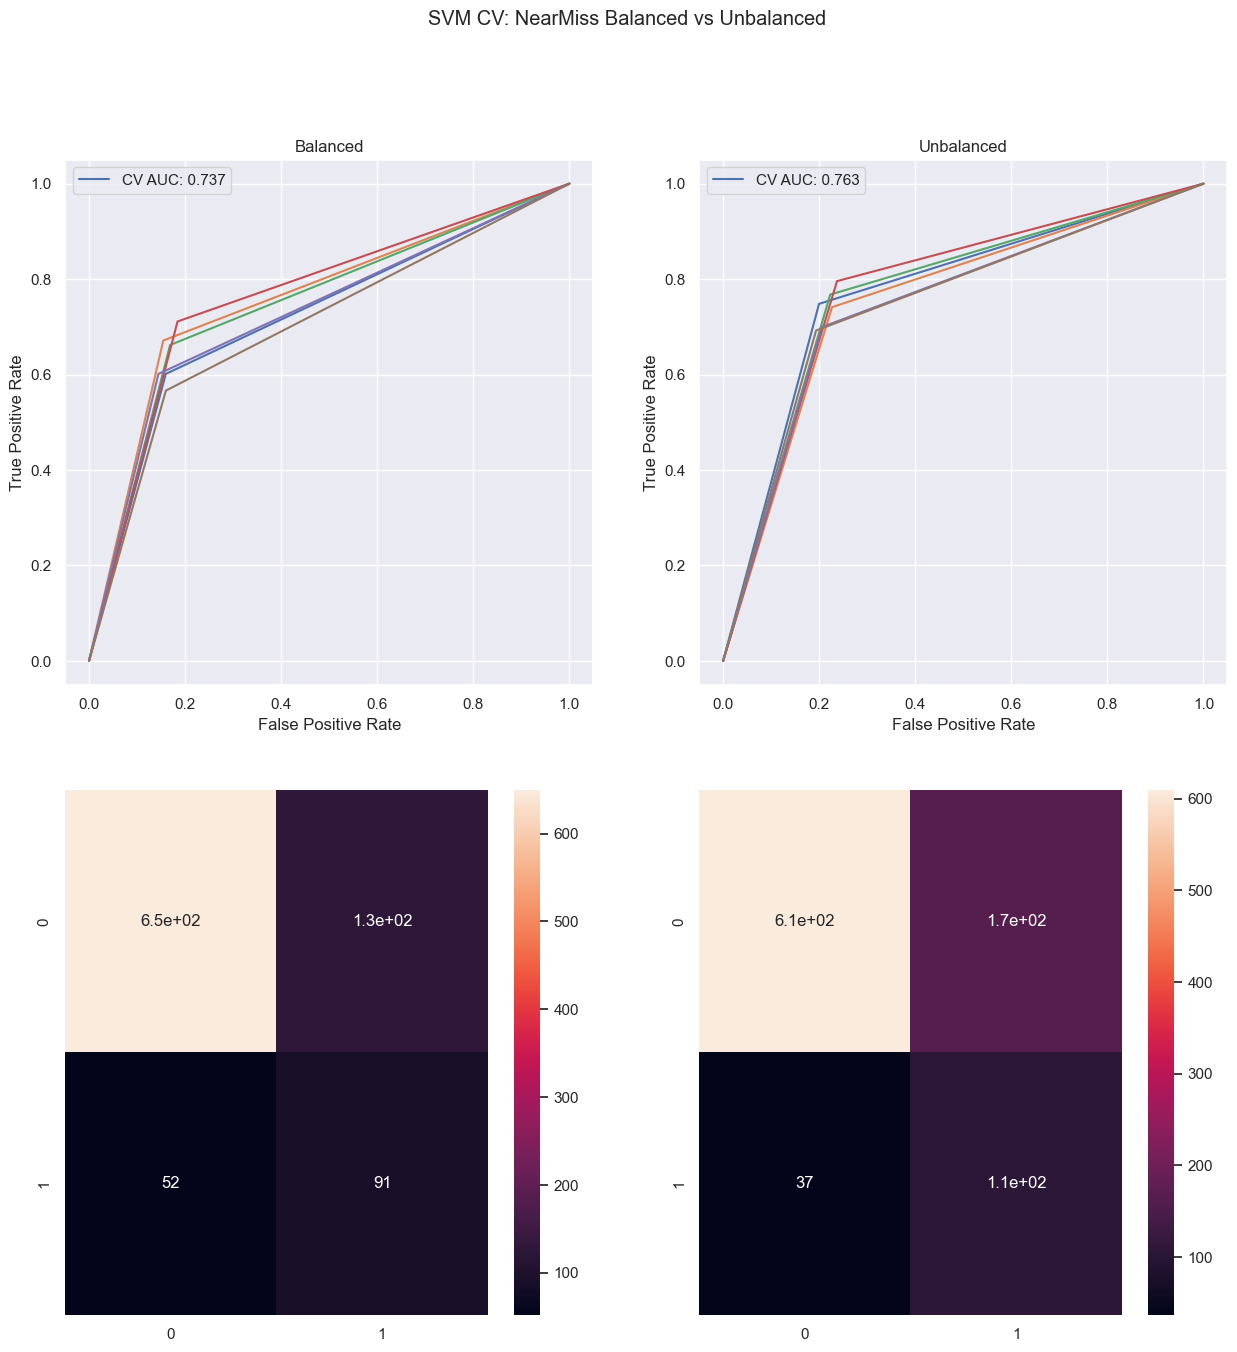

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle(f'SVM CV: NearMiss Balanced vs Unbalanced')
sns.set(font_scale = 1)

cflist = []
cflist_resampled = []
for res_resampled, res in zip(results_resampled, results):

    fpr, tpr, _ = roc_curve(res_resampled[0],  res_resampled[1])
    auc = roc_auc_score(res_resampled[0],  res_resampled[1])
    cf = confusion_matrix(res_resampled[0],  res_resampled[1])
    cflist_resampled.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,0])
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].set_title('Balanced')

    
    
    fpr, tpr, _ = roc_curve(res[0],  res[1])
    auc = roc_auc_score(res[0],  res[1])
    cf = confusion_matrix(res[0],  res[1])
    cflist.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,1])
    axes[0,1].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,1].set_title('Unbalanced')
    
    
axes[0,0].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][0],3)}"])
axes[0,1].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][1],3)}"])

cf = np.mean(cflist,axis=0)
cf_resampled = np.mean(cflist_resampled,axis=0)
sns.heatmap(pd.DataFrame(cf_resampled) , annot=True, ax = axes[1,0])
sns.heatmap(pd.DataFrame(cf) , annot=True, ax = axes[1,1])   
plt.show()

    

# Classification Trees

### SMOTE Oversampling

In [48]:
classi_tree = DecisionTreeClassifier(criterion='gini', class_weight='balanced')
sfs = SFS(classi_tree, n_features_to_select='auto', scoring='roc_auc', direction="forward", n_jobs=-1)
sfs.fit(X, y)
features= pd.DataFrame(sfs.get_feature_names_out(), columns=['Features'])
X_new = sfs.transform(X)
X_new = pd.DataFrame(X_new, columns = features.Features)

In [50]:
features

Features
0       Location
1       Rainfall
2       Sunshine
3     WindDir3pm
4   WindSpeed3pm
5    Humidity3pm
6    Pressure3pm
7       Cloud3pm
8        Temp9am
9        Temp3pm
10     RainToday

In [51]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, test_size=0.2, random_state=13)
Xtrain_resampled, ytrain_resampled = smote.fit_resample(Xtrain, ytrain)

In [52]:
Xtrain_resampled.head()

Features  Location  Rainfall  Sunshine  WindDir3pm  WindSpeed3pm  Humidity3pm  \
0             11.0       0.0       8.2         5.0           7.0         44.0   
1              9.0       0.0      13.3         3.0          13.0         20.0   
2             26.0       0.0      13.3         8.0          17.0         37.0   
3             20.0       0.0       8.0        13.0          19.0         19.0   
4             15.0       0.0      11.8         4.0          13.0         63.0   

Features  Pressure3pm  Cloud3pm  Temp9am  Temp3pm  RainToday  
0              1022.4       2.0     11.8     20.7        0.0  
1              1015.8       0.0     19.9     28.8        0.0  
2              1007.7       4.5     21.2     30.7        0.0  
3              1005.6       5.0     22.5     32.3        0.0  
4              1009.6       3.0     25.9     28.3        0.0

In [53]:
classi_tree = DecisionTreeClassifier(random_state=2, criterion='gini', class_weight='balanced')
classi_tree = classi_tree.fit(Xtrain_resampled, ytrain_resampled)
classi_tree.fit(Xtrain_resampled, ytrain_resampled)

ypred_resampled = classi_tree.predict(Xtest)
scores = classification_report(ytest, ypred_resampled)
roc_auc = roc_auc_score(ytest, ypred_resampled)
print('\t\t\t====Balanced===')
print(scores)
print(f'roc_auc score: {roc_auc}')

			====Balanced===
              precision    recall  f1-score   support

           0       0.90      0.83      0.87       934
           1       0.35      0.49      0.40       168

    accuracy                           0.78      1102
   macro avg       0.62      0.66      0.64      1102
weighted avg       0.82      0.78      0.80      1102

roc_auc score: 0.6610711736514734


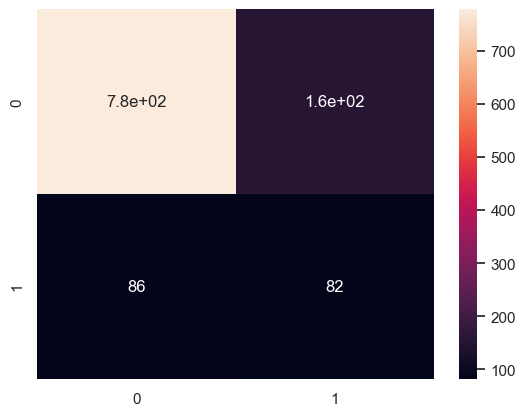

In [54]:
cf = confusion_matrix(ytest,  ypred_resampled)
sns.heatmap(pd.DataFrame(cf) , annot=True)
plt.show()

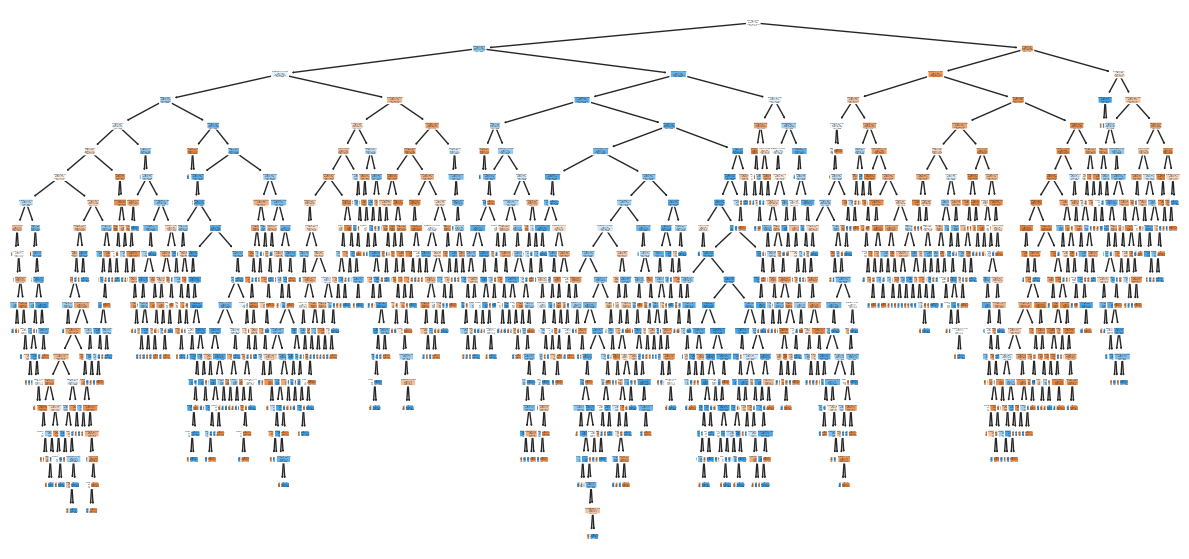

In [55]:
plt.figure(figsize=(15, 7))
plot_tree(classi_tree,
          filled=True,
          rounded=True,
          class_names=['Alive','Dead'],
          feature_names=X.columns)
plt.show()

###  Tuning CV

In [56]:
path = classi_tree.cost_complexity_pruning_path(Xtrain_resampled, ytrain_resampled)
alphas = path.ccp_alphas
ccp_alphas = alphas[:-1] #exclude the maximum value of alpha bc it leads to the the root of the tree

alpha_values = []
for a in alphas:
    classi_tree = DecisionTreeClassifier(random_state=0, ccp_alpha = a, criterion='gini', class_weight='balanced')
    scores_crossval = cross_val_score(classi_tree, Xtrain_resampled, ytrain_resampled, cv=5, scoring='roc_auc', n_jobs=-1)
    alpha_values.append([a, np.mean(scores_crossval), np.std(scores_crossval)])
    

    
alpha_results = pd.DataFrame(alpha_values, columns=['alpha', 'roc_auc', 'std'])
best_alpha = alpha_results.sort_values(by='roc_auc', ascending=False).iloc[0,0]
print(f'Best alpha: {best_alpha}')

Best alpha: 0.0006240844813299237


In [57]:
classi_tree_pruned = DecisionTreeClassifier(random_state = 2, ccp_alpha=best_alpha, criterion='gini', class_weight='balanced')
classi_tree_pruned.fit(Xtrain_resampled, ytrain_resampled)

#===========balanced
ypred = classi_tree_pruned.predict(Xtest)
scores = classification_report(ytest, ypred)
roc_auc = roc_auc_score(ytest, ypred)
print('\t\t\t====Balanced===')
print(scores)
print(f'roc_auc score: {roc_auc}')

			====Balanced===
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       934
           1       0.39      0.50      0.44       168

    accuracy                           0.80      1102
   macro avg       0.65      0.68      0.66      1102
weighted avg       0.83      0.80      0.81      1102

roc_auc score: 0.6788008565310493


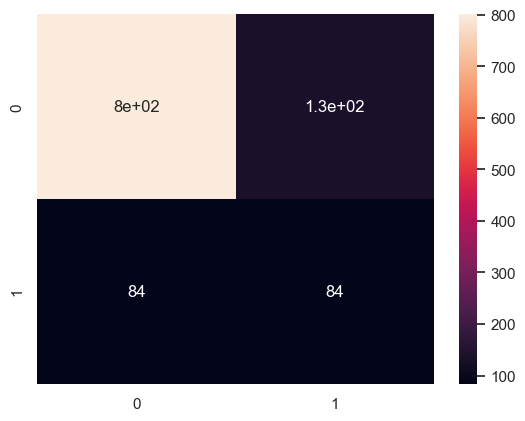

In [58]:
cf = confusion_matrix(ytest,  ypred)
sns.heatmap(pd.DataFrame(cf) , annot=True)
plt.show()

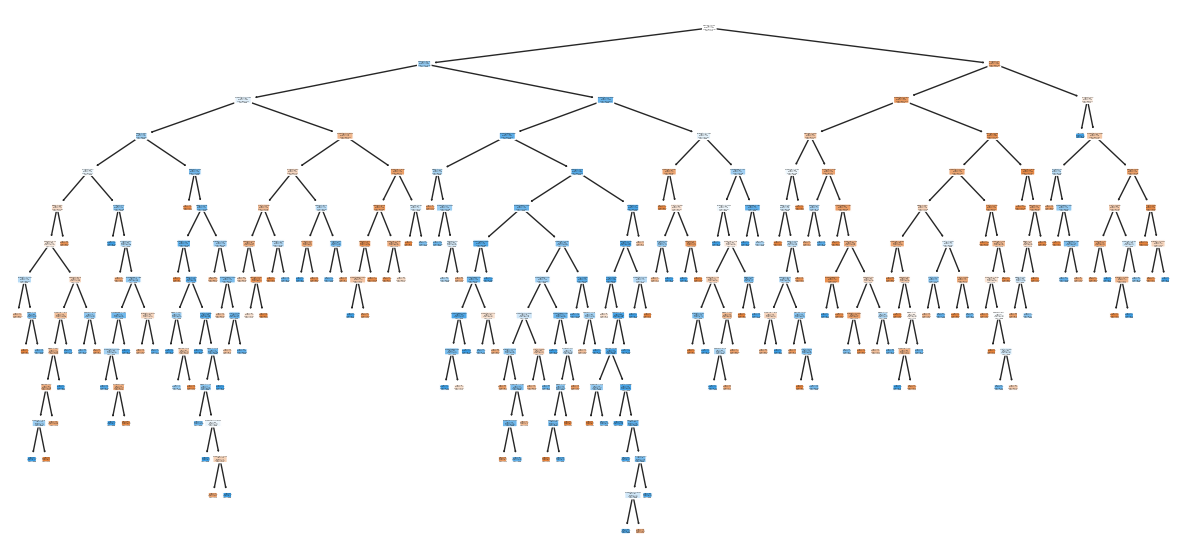

In [59]:
plt.figure(figsize=(15, 7))
plot_tree(classi_tree_pruned,
          filled=True,
          rounded=True,
          class_names=['Alive','Dead'],
          feature_names=X.columns)
plt.show()

### NearMiss Undersampling

In [60]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, test_size=0.2, random_state=13)
Xtrain_resampled, ytrain_resampled = nm.fit_resample(Xtrain, ytrain)
Xtrain.head()

Features  Location  Rainfall  Sunshine  WindDir3pm  WindSpeed3pm  Humidity3pm  \
1039          11.0       0.0       8.2         5.0           7.0         44.0   
2443           9.0       0.0      13.3         3.0          13.0         20.0   
2434          26.0       0.0      13.3         8.0          17.0         37.0   
127           20.0       0.0       8.0        13.0          19.0         19.0   
3420          15.0       0.0      11.8         4.0          13.0         63.0   

Features  Pressure3pm  Cloud3pm  Temp9am  Temp3pm  RainToday  
1039           1022.4       2.0     11.8     20.7        0.0  
2443           1015.8       0.0     19.9     28.8        0.0  
2434           1007.7       4.5     21.2     30.7        0.0  
127            1005.6       5.0     22.5     32.3        0.0  
3420           1009.6       3.0     25.9     28.3        0.0

In [61]:
classi_tree = DecisionTreeClassifier(random_state=2, criterion='gini', class_weight='balanced')
classi_tree = classi_tree.fit(Xtrain_resampled, ytrain_resampled)
classi_tree.fit(Xtrain_resampled, ytrain_resampled)

ypred_resampled = classi_tree.predict(Xtest)
scores = classification_report(ytest, ypred_resampled)
roc_auc = roc_auc_score(ytest, ypred_resampled)
print('\t\t\t====Balanced===')
print(scores)
print(f'roc_auc score: {roc_auc}')

			====Balanced===
              precision    recall  f1-score   support

           0       0.88      0.49      0.63       934
           1       0.19      0.64      0.29       168

    accuracy                           0.51      1102
   macro avg       0.53      0.57      0.46      1102
weighted avg       0.78      0.51      0.58      1102

roc_auc score: 0.5671459161823188


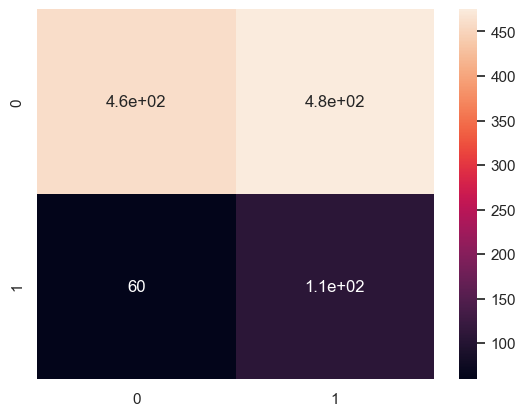

In [62]:
cf = confusion_matrix(ytest,  ypred_resampled)
sns.heatmap(pd.DataFrame(cf) , annot=True)
plt.show()

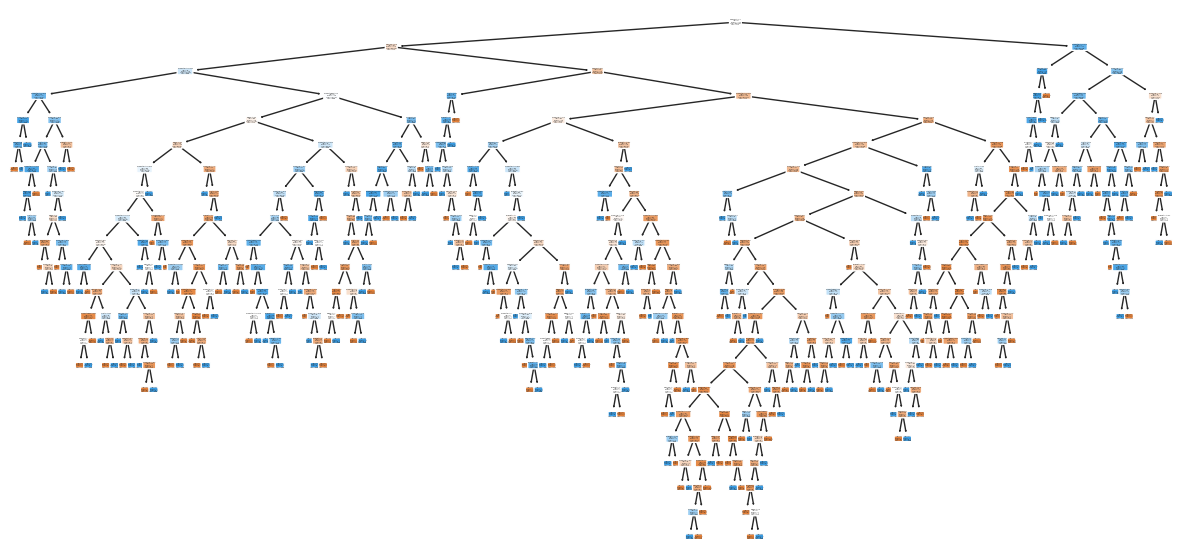

In [63]:
plt.figure(figsize=(15, 7))
plot_tree(classi_tree,
          filled=True,
          rounded=True,
          class_names=['Alive','Dead'],
          feature_names=X.columns)
plt.show()

### Tuning CV

In [64]:
path = classi_tree.cost_complexity_pruning_path(Xtrain_resampled, ytrain_resampled)
alphas = path.ccp_alphas
ccp_alphas = alphas[:-1] #exclude the maximum value of alpha bc it leads to the the root of the tree

alpha_values = []
for a in alphas:
    classi_tree = DecisionTreeClassifier(random_state=0, ccp_alpha = a, criterion='gini', class_weight='balanced')
    scores_crossval = cross_val_score(classi_tree, Xtrain_resampled, ytrain_resampled, cv=5, scoring='roc_auc', n_jobs=-1)
    alpha_values.append([a, np.mean(scores_crossval), np.std(scores_crossval)])
    

    
alpha_results = pd.DataFrame(alpha_values, columns=['alpha', 'roc_auc', 'std'])
best_alpha = alpha_results.sort_values(by='roc_auc', ascending=False).iloc[0,0]
print(f'Best alpha: {best_alpha}')

Best alpha: 0.005033411250736572


In [65]:
classi_tree_pruned = DecisionTreeClassifier(random_state = 2, ccp_alpha=best_alpha, criterion='gini', class_weight='balanced')
classi_tree_pruned.fit(Xtrain_resampled, ytrain_resampled)

#===========balanced
ypred = classi_tree_pruned.predict(Xtest)
scores = classification_report(ytest, ypred)
roc_auc = roc_auc_score(ytest, ypred)
print('\t\t\t====Balanced===')
print(scores)
print(f'roc_auc score: {roc_auc}')

			====Balanced===
              precision    recall  f1-score   support

           0       0.90      0.48      0.62       934
           1       0.20      0.71      0.31       168

    accuracy                           0.51      1102
   macro avg       0.55      0.59      0.47      1102
weighted avg       0.79      0.51      0.57      1102

roc_auc score: 0.5948302233098808


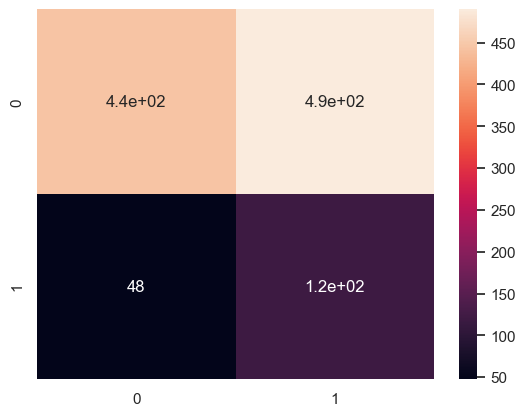

In [66]:
cf = confusion_matrix(ytest,  ypred)
sns.heatmap(pd.DataFrame(cf) , annot=True)
plt.show()

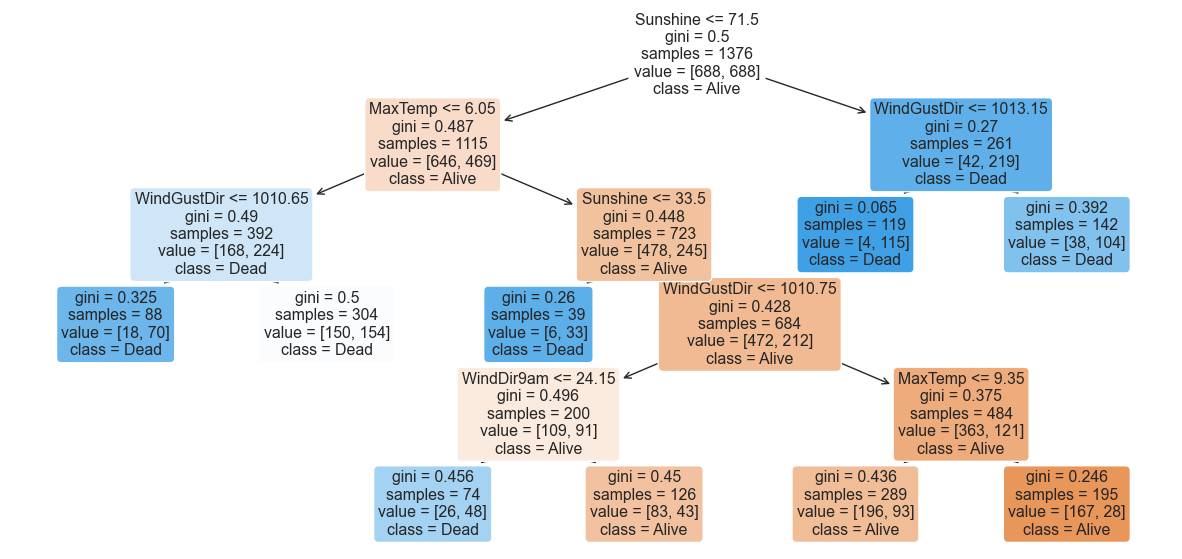

In [67]:
plt.figure(figsize=(15, 7))
plot_tree(classi_tree_pruned,
          filled=True,
          rounded=True,
          class_names=['Alive','Dead'],
          feature_names=X.columns)
plt.show()

### Unbalanced

In [68]:
Xtrain.shape

(4408, 11)

In [69]:
#===========unbalanced
classi_tree_unbalanced = DecisionTreeClassifier(random_state=2, criterion='entropy',class_weight='balanced' )
classi_tree_unbalanced = classi_tree_unbalanced.fit(Xtrain, ytrain)
classi_tree_unbalanced.fit(Xtrain, ytrain)

ypred = classi_tree_unbalanced.predict(Xtest)
scores = classification_report(ytest, ypred)
roc_auc = roc_auc_score(ytest, ypred)
print('\t\t\t====Balanced===')
print(scores)
print(f'roc_auc score: {roc_auc}')

			====Balanced===
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       934
           1       0.42      0.44      0.43       168

    accuracy                           0.82      1102
   macro avg       0.66      0.66      0.66      1102
weighted avg       0.82      0.82      0.82      1102

roc_auc score: 0.6645635770368105


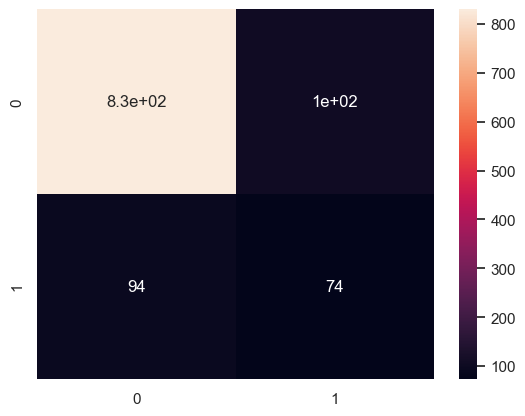

In [70]:
cf = confusion_matrix(ytest,  ypred)
sns.heatmap(pd.DataFrame(cf) , annot=True)
plt.show()

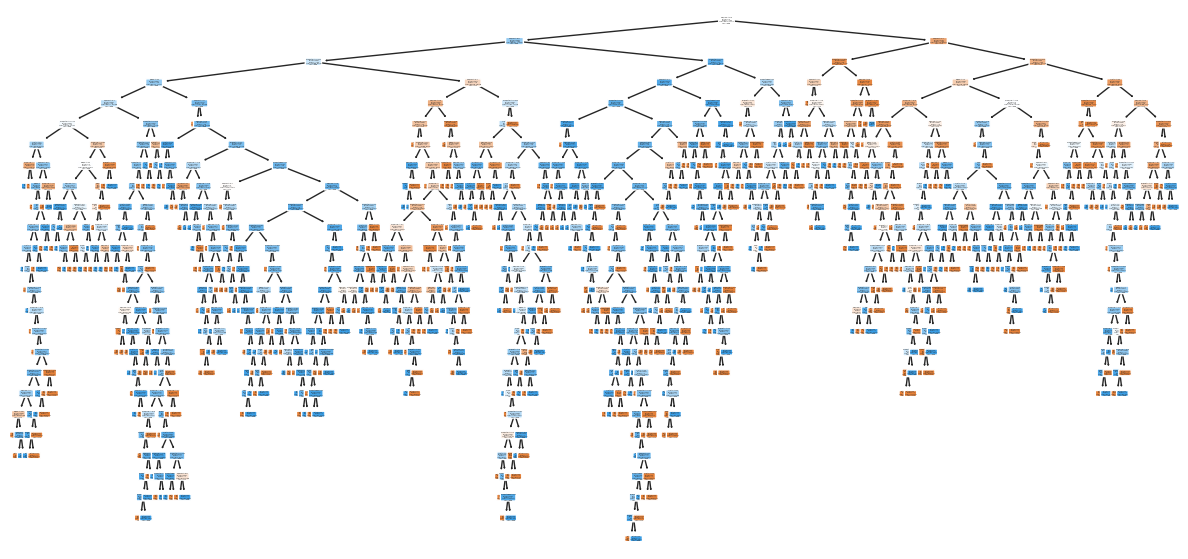

In [71]:

plt.figure(figsize=(15, 7))
plot_tree(classi_tree_unbalanced,
          filled=True,
          rounded=True,
          class_names=['Alive','Dead'],
          feature_names=X.columns)
plt.show()

### Unalanced Tuning CV

In [72]:
path = classi_tree_unbalanced.cost_complexity_pruning_path(Xtrain, ytrain)
alphas = path.ccp_alphas
ccp_alphas = alphas[:-1] #exclude the maximum value of alpha bc it leads to the the root of the tree

alpha_values = []
for a in alphas:
    classi_tree = DecisionTreeClassifier(random_state=0, ccp_alpha = a, criterion='entropy', class_weight='balanced')
    scores_crossval = cross_val_score(classi_tree, Xtrain, ytrain, cv=5, scoring='roc_auc', n_jobs=-1)
    alpha_values.append([a, np.mean(scores_crossval), np.std(scores_crossval)])
    

    
alpha_results = pd.DataFrame(alpha_values, columns=['alpha', 'roc_auc', 'std'])
best_alpha = alpha_results.sort_values(by='roc_auc', ascending=False).iloc[0,0]
print(f'Best alpha: {best_alpha}')

Best alpha: 0.004788046108287682


In [73]:
classi_tree_unbalanced_pruned = DecisionTreeClassifier(random_state = 2, ccp_alpha=best_alpha, criterion='entropy', class_weight='balanced')
classi_tree_unbalanced_pruned.fit(Xtrain, ytrain)

#===========balanced
ypred = classi_tree_unbalanced_pruned.predict(Xtest)
scores = classification_report(ytest, ypred)
roc_auc = roc_auc_score(ytest, ypred)
print('\t\t\t====Unbalanced===')
print(scores)
print(f'roc_auc score: {roc_auc}')

			====Unbalanced===
              precision    recall  f1-score   support

           0       0.95      0.72      0.82       934
           1       0.33      0.78      0.47       168

    accuracy                           0.73      1102
   macro avg       0.64      0.75      0.64      1102
weighted avg       0.85      0.73      0.76      1102

roc_auc score: 0.7490886611603956


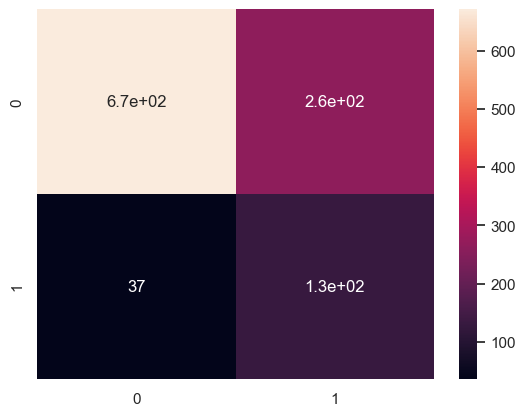

In [74]:
cf = confusion_matrix(ytest,  ypred)
sns.heatmap(pd.DataFrame(cf) , annot=True)
plt.show()

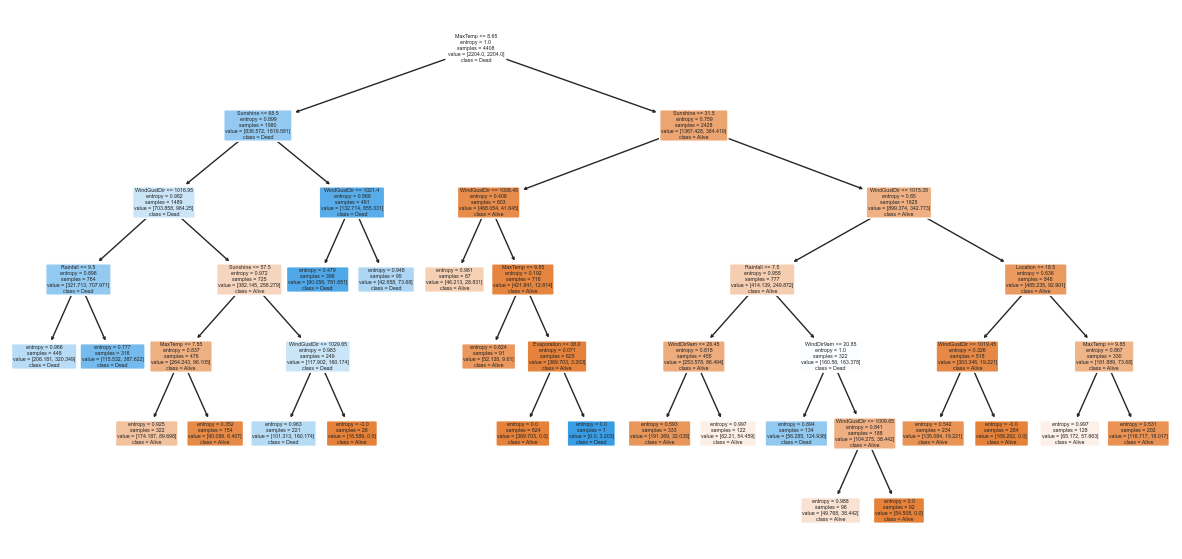

In [75]:
plt.figure(figsize=(15, 7))
plot_tree(classi_tree_unbalanced_pruned,
          filled=True,
          rounded=True,
          class_names=['Alive','Dead'],
          feature_names=X.columns)
plt.show()

# ANN

### SMOTE Oversampling

In [78]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

In [79]:
scaler = StandardScaler()
Xscale = scaler.fit_transform(X)
Xscale = pd.DataFrame(Xscale, columns=X.columns)
Xscale.head()

Location   MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustDir  \
0 -1.500203 -1.045596 -0.691998 -0.402945    -0.231272 -0.513102     0.467309   
1  1.487796 -0.230252  0.118126 -0.402945     0.239521  0.764688    -1.545008   
2 -1.141643  0.193100  1.738374 -0.402945     0.549729  0.625798     0.020127   
3 -0.783084 -0.841760 -1.181130  0.103205    -1.374628  0.098015     1.585262   
4 -1.022124 -1.641424 -1.700832 -0.402945    -1.374628 -0.540880     1.138081   

   WindGustSpeed  WindDir9am  WindDir3pm  ...  Humidity9am  Humidity3pm  \
0      -0.066277    1.324720    0.448873  ...     0.682764     1.139627   
1      -0.462565    0.229450   -1.082102  ...    -0.934155    -0.325374   
2      -0.264421   -1.522982   -1.082102  ...    -2.071987    -1.953152   
3       0.528155    0.886612    1.761137  ...     1.221738     0.000182   
4      -0.759782   -1.522982    1.542426  ...     0.982194     0.434256   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm   Temp9am   Temp3pm  \
0     1.022324     1.103138  1.505717 -0.039147 -0.835901 -0.833125   
1     0.255415     0.166745 -0.753832 -0.439708  0.427040  0.093308   
2    -0.399654    -0.579196  0.187646  0.161133  1.247951  1.757746   
3     0.830596     0.611135 -1.130424 -1.240830 -1.025342 -1.257086   
4     1.246006     0.912685 -1.130424  1.162535 -1.751533 -1.633940   

   RainToday     Month  
0  -0.243745  0.789099  
1  -0.243745  0.203715  
2  -0.243745  1.667173  
3  -0.243745 -0.088976  
4  -0.243745  0.203715  

[5 rows x 22 columns]

In [80]:
ann = MLPClassifier(max_iter=2000,
                    verbose  = True,
                    early_stopping = True)

In [81]:
sfs = SFS(ann, n_features_to_select='auto', scoring='roc_auc', direction="forward", n_jobs=-1)
sfs.fit(Xscale, y)
features= pd.DataFrame(sfs.get_feature_names_out(), columns=['Features'])
X_new = sfs.transform(X)
X_new = pd.DataFrame(X_new, columns = features.Features)

In [82]:
features

Features
0        Location
1        Sunshine
2     WindGustDir
3   WindGustSpeed
4      WindDir3pm
5     Humidity3pm
6     Pressure9am
7     Pressure3pm
8        Cloud3pm
9         Temp3pm
10          Month

In [83]:
dropfeats = X.drop(features.Features, axis=1)
X_new = X.drop(dropfeats.columns, axis=1)
X_new.columns

Index(['Location', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir3pm',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud3pm', 'Temp3pm',
       'Month'],
      dtype='object')

In [84]:
from tensorflow import keras
from tensorflow.keras import layers,Sequential
import tensorflow as tf

Xnorm_new = scale(X_new)
Xnorm_new = pd.DataFrame(Xnorm_new, columns=X_new.columns)

Xtrain, Xtest, ytrain, ytest = train_test_split(Xnorm_new, y, test_size=0.2, random_state=2)
Xtrain_resampled, ytrain_resampled = smote.fit_resample(Xtrain, ytrain)
Xtrain_resampled.head()

Location  Sunshine  WindGustDir  WindGustSpeed  WindDir3pm  Humidity3pm  \
0  1.368276 -0.318656    -0.650645      -2.245862   -1.300813     0.108701   
1 -1.500203  1.236915     0.243718       1.419803    0.230162    -1.519078   
2  0.173076  0.264683     0.020127       0.131867    0.011452     1.356664   
3  0.651156 -1.874227     1.138081      -0.759782    0.886294     0.651294   
4 -0.065964  1.209137     0.243718      -0.264421   -1.082102     0.054441   

   Pressure9am  Pressure3pm  Cloud3pm   Temp3pm     Month  
0     0.910483     1.007912  0.161133 -1.367002 -0.674359  
1     0.255415     0.230229 -1.641391  0.014796 -1.259742  
2    -0.831040    -0.325259 -1.240830 -0.048013 -0.967051  
3    -0.128040    -0.198290  1.162535 -0.628996 -0.088976  
4     0.223460     0.214358 -1.240830 -0.048013  1.374482

In [85]:
model=tf.keras.Sequential([
    layers.Flatten(input_shape=(X_new.shape[1], )),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256,activation='relu'),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 11)                0         
                                                                 
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [86]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy', 
              metrics=["AUC"])

callback = keras.callbacks.EarlyStopping(monitor='val_auc', patience=3)
history = model.fit(Xtrain_resampled, ytrain_resampled, 
        epochs=150,
        validation_data=(Xtest, ytest),
        batch_size=32, 
        callbacks=[callback],)

Epoch 1/150
233/233 [==============================] - 2s 3ms/step - loss: 0.6909 - auc: 0.5363 - val_loss: 0.6800 - val_auc: 0.7202
Epoch 2/150
233/233 [==============================] - 1s 3ms/step - loss: 0.6848 - auc: 0.6015 - val_loss: 0.6650 - val_auc: 0.7644
Epoch 3/150
233/233 [==============================] - 1s 3ms/step - loss: 0.6789 - auc: 0.6379 - val_loss: 0.6509 - val_auc: 0.7820
Epoch 4/150
233/233 [==============================] - 1s 2ms/step - loss: 0.6679 - auc: 0.6826 - val_loss: 0.6308 - val_auc: 0.7940
Epoch 5/150
233/233 [==============================] - 1s 2ms/step - loss: 0.6518 - auc: 0.7176 - val_loss: 0.6042 - val_auc: 0.8043
Epoch 6/150
233/233 [==============================] - 1s 3ms/step - loss: 0.6314 - auc: 0.7382 - val_loss: 0.5726 - val_auc: 0.8108
Epoch 7/150
233/233 [==============================] - 1s 2ms/step - loss: 0.6065 - auc: 0.7600 - val_loss: 0.5434 - val_auc: 0.8166
Epoch 8/150
233/233 [==============================] - 1s 2ms/step - 

233/233 [==============================] - 1s 3ms/step - loss: 0.4774 - auc: 0.8523 - val_loss: 0.4687 - val_auc: 0.8520
Epoch 63/150
233/233 [==============================] - 1s 3ms/step - loss: 0.4766 - auc: 0.8530 - val_loss: 0.4694 - val_auc: 0.8523
Epoch 64/150
233/233 [==============================] - 1s 3ms/step - loss: 0.4747 - auc: 0.8542 - val_loss: 0.4697 - val_auc: 0.8524
Epoch 65/150
233/233 [==============================] - 1s 3ms/step - loss: 0.4777 - auc: 0.8519 - val_loss: 0.4656 - val_auc: 0.8526
Epoch 66/150
233/233 [==============================] - 1s 3ms/step - loss: 0.4778 - auc: 0.8522 - val_loss: 0.4651 - val_auc: 0.8529
Epoch 67/150
233/233 [==============================] - 1s 3ms/step - loss: 0.4737 - auc: 0.8545 - val_loss: 0.4652 - val_auc: 0.8531
Epoch 68/150
233/233 [==============================] - 1s 3ms/step - loss: 0.4723 - auc: 0.8562 - val_loss: 0.4642 - val_auc: 0.8534
Epoch 69/150
233/233 [==============================] - 1s 3ms/step - loss:

<AxesSubplot:title={'center':'Loss'}>

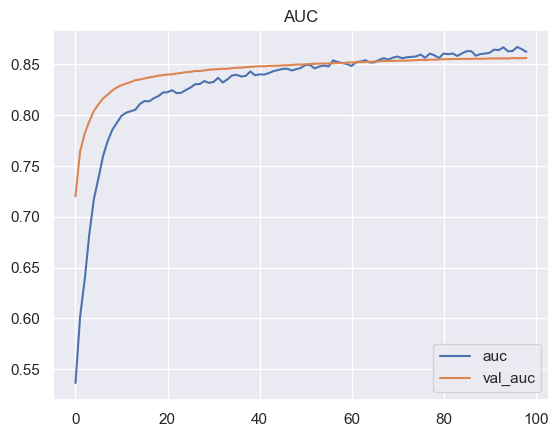

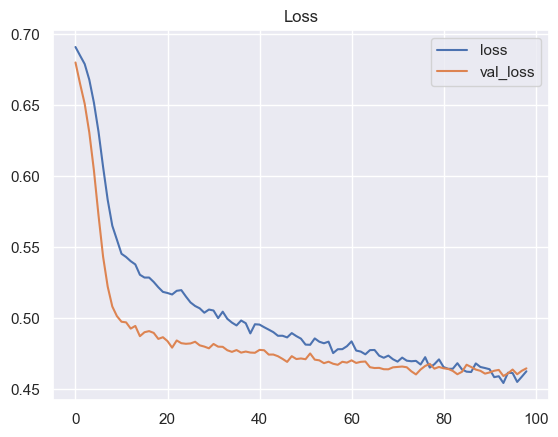

In [87]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['auc', 'val_auc']].plot(title="AUC")
history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss")

35/35 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       929
           1       0.38      0.75      0.51       173

    accuracy                           0.77      1102
   macro avg       0.66      0.76      0.68      1102
weighted avg       0.86      0.77      0.80      1102



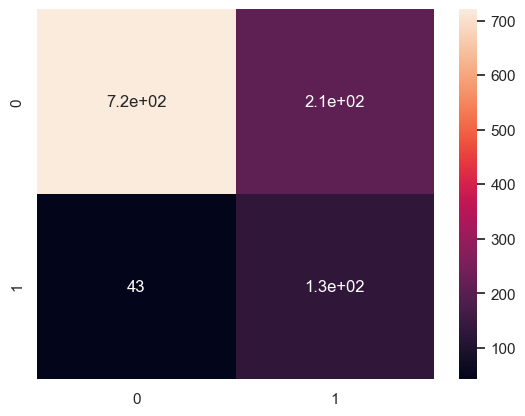

In [88]:
ypred = model.predict(Xtest)
cf = confusion_matrix(ytest, ypred.round())
sns.heatmap(pd.DataFrame(cf) , annot=True)
print(classification_report(ytest,ypred.round()))

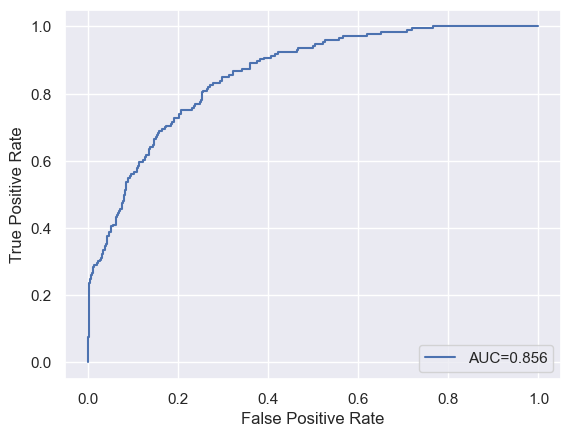

In [89]:
#create ROC curve
fpr, tpr, _ = roc_curve(ytest,  ypred)
auc = roc_auc_score(ytest, ypred)


plt.plot(fpr,tpr,label="AUC="+str(round(auc,3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### NearMiss Undersampling

In [99]:
from tensorflow import keras
from tensorflow.keras import layers,Sequential
import tensorflow as tf

Xnorm_new = scale(X_new)
Xnorm_new = pd.DataFrame(Xnorm_new, columns=X_new.columns)

Xtrain, Xtest, ytrain, ytest = train_test_split(Xnorm_new, y, test_size=0.2, random_state=2)
Xtrain_resampled, ytrain_resampled = nm.fit_resample(Xtrain, ytrain)

In [100]:
Xtrain

Location  Sunshine  WindGustDir  WindGustSpeed  WindDir3pm  Humidity3pm  \
1561  1.368276 -0.318656    -0.650645      -2.245862   -1.300813     0.108701   
882  -1.500203  1.236915     0.243718       1.419803    0.230162    -1.519078   
822   0.173076  0.264683     0.020127       0.131867    0.011452     1.356664   
5369  0.651156 -1.874227     1.138081      -0.759782    0.886294     0.651294   
994  -0.065964  1.209137     0.243718      -0.264421   -1.082102     0.054441   
...        ...       ...          ...            ...         ...          ...   
3335 -0.663564  0.848022    -0.650645       0.825371   -0.863391    -1.410559   
1099 -0.783084  0.181349     1.808853      -1.849574    1.542426    -0.867966   
2514 -0.663564  1.403583    -1.545008       2.113307    1.323716    -0.922226   
3606  0.770676  0.792466     0.914490      -0.264421    1.542426     0.325738   
2575 -0.663564  0.625798    -1.321417      -0.264421    0.230162    -0.542411   

      Pressure9am  Pressure3pm  Cloud3pm   Temp3pm     Month  
1561     0.910483     1.007912  0.161133 -1.367002 -0.674359  
882      0.255415     0.230229 -1.641391  0.014796 -1.259742  
822     -0.831040    -0.325259 -1.240830 -0.048013 -0.967051  
5369    -0.128040    -0.198290  1.162535 -0.628996 -0.088976  
994      0.223460     0.214358 -1.240830 -0.048013  1.374482  
...           ...          ...       ...       ...       ...  
3335     1.805210     1.626884 -1.641391 -0.283546  1.081790  
1099     1.821187     1.991919  0.161133 -1.429811  0.203715  
2514    -1.565995    -1.261653 -1.240830  1.757746 -1.552434  
3606    -0.767131    -1.134684 -0.840269  1.537915  0.789099  
2575     1.869119     1.563400 -1.240830 -0.754614  0.496407  

[4408 rows x 11 columns]

In [101]:
model=tf.keras.Sequential([
    layers.Flatten(input_shape=(X_new.shape[1], )),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256,activation='relu'),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 11)                0         
                                                                 
 dense_14 (Dense)            (None, 64)                768       
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 128)               8320      
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)              

In [102]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy', 
              metrics=["AUC"])

callback = keras.callbacks.EarlyStopping(monitor='val_auc', patience=3)
history = model.fit(Xtrain_resampled, ytrain_resampled, 
        epochs=150,
        validation_data=(Xtest, ytest),
        batch_size=32, 
        callbacks=[callback],)

Epoch 1/150
43/43 [==============================] - 1s 8ms/step - loss: 0.6976 - auc: 0.4741 - val_loss: 0.6833 - val_auc: 0.4986
Epoch 2/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6965 - auc: 0.4749 - val_loss: 0.6886 - val_auc: 0.5387
Epoch 3/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6937 - auc: 0.5092 - val_loss: 0.6925 - val_auc: 0.5738
Epoch 4/150
43/43 [==============================] - 0s 3ms/step - loss: 0.6917 - auc: 0.5323 - val_loss: 0.6966 - val_auc: 0.6151
Epoch 5/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6895 - auc: 0.5561 - val_loss: 0.6992 - val_auc: 0.6326
Epoch 6/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6895 - auc: 0.5613 - val_loss: 0.7020 - val_auc: 0.6390
Epoch 7/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6888 - auc: 0.5688 - val_loss: 0.7050 - val_auc: 0.6658
Epoch 8/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6890 - a

<AxesSubplot:title={'center':'Loss'}>

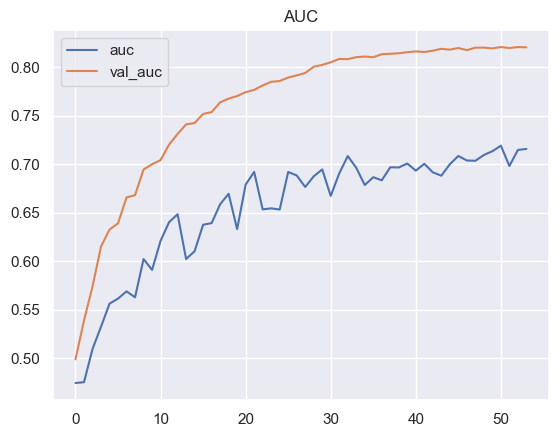

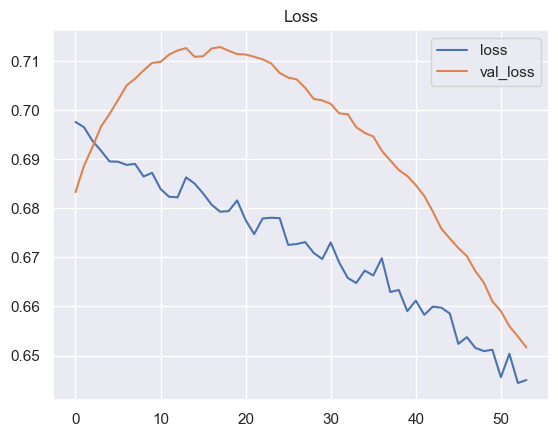

In [103]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['auc', 'val_auc']].plot(title="AUC")
history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss")

35/35 [==============================] - 0s 991us/step
              precision    recall  f1-score   support

           0       0.94      0.71      0.81       929
           1       0.33      0.77      0.46       173

    accuracy                           0.72      1102
   macro avg       0.64      0.74      0.63      1102
weighted avg       0.85      0.72      0.75      1102



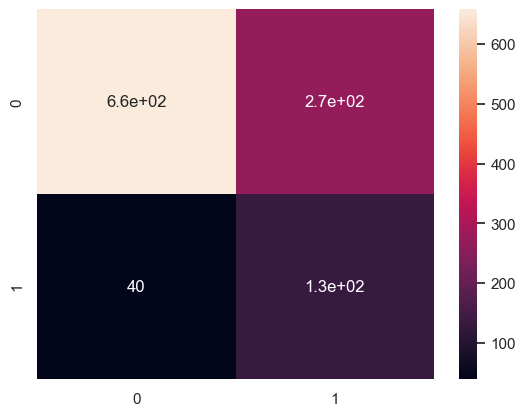

In [104]:
ypred = model.predict(Xtest)
cf = confusion_matrix(ytest, ypred.round())
sns.heatmap(pd.DataFrame(cf) , annot=True)
print(classification_report(ytest,ypred.round()))

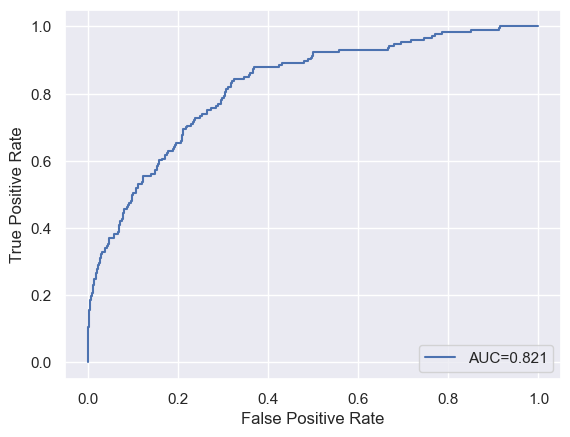

In [105]:
#create ROC curve
fpr, tpr, _ = roc_curve(ytest,  ypred)
auc = roc_auc_score(ytest, ypred)


plt.plot(fpr,tpr,label="AUC="+str(round(auc,3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Unbalanced

In [106]:
Xnorm_new = scale(X_new)
Xnorm_new = pd.DataFrame(Xnorm_new, columns=X_new.columns)

Xtrain, Xtest, ytrain, ytest = train_test_split(Xnorm_new, y, test_size=0.2, random_state=2)
Xtrain_resampled, ytrain_resampled = smote.fit_resample(Xtrain, ytrain)

In [107]:
model=tf.keras.Sequential([
    layers.Flatten(input_shape=(X_new.shape[1], )),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256,activation='relu'),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 11)                0         
                                                                 
 dense_21 (Dense)            (None, 64)                768       
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 128)               8320      
                                                                 
 dense_24 (Dense)            (None, 128)               16512     
                                                                 
 dropout_10 (Dropout)        (None, 128)              

In [108]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy', 
              metrics=["AUC"])

callback = keras.callbacks.EarlyStopping(monitor='val_auc', patience=3)
history = model.fit(Xtrain, ytrain, 
        epochs=150,
        validation_data=(Xtest, ytest),
        batch_size=32, 
        callbacks=[callback],)

Epoch 1/150
138/138 [==============================] - 1s 4ms/step - loss: 0.6389 - auc: 0.4614 - val_loss: 0.6334 - val_auc: 0.5928
Epoch 2/150
138/138 [==============================] - 0s 3ms/step - loss: 0.5579 - auc: 0.5018 - val_loss: 0.5680 - val_auc: 0.6093
Epoch 3/150
138/138 [==============================] - 0s 3ms/step - loss: 0.4954 - auc: 0.5057 - val_loss: 0.5066 - val_auc: 0.6490
Epoch 4/150
138/138 [==============================] - 0s 3ms/step - loss: 0.4541 - auc: 0.5491 - val_loss: 0.4633 - val_auc: 0.6973
Epoch 5/150
138/138 [==============================] - 0s 3ms/step - loss: 0.4411 - auc: 0.5552 - val_loss: 0.4400 - val_auc: 0.7378
Epoch 6/150
138/138 [==============================] - 0s 3ms/step - loss: 0.4274 - auc: 0.6015 - val_loss: 0.4246 - val_auc: 0.7656
Epoch 7/150
138/138 [==============================] - 0s 3ms/step - loss: 0.4199 - auc: 0.6247 - val_loss: 0.4135 - val_auc: 0.7857
Epoch 8/150
138/138 [==============================] - 0s 3ms/step - 

138/138 [==============================] - 0s 3ms/step - loss: 0.3514 - auc: 0.8035 - val_loss: 0.3236 - val_auc: 0.8542


<AxesSubplot:title={'center':'Loss'}>

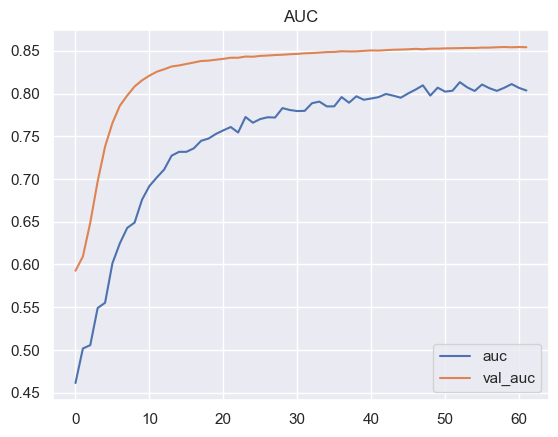

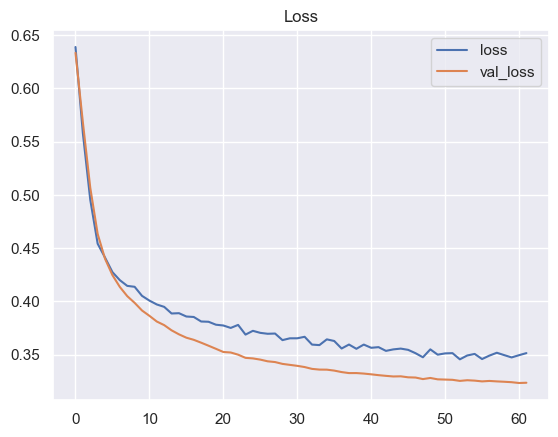

In [109]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['auc', 'val_auc']].plot(title="AUC")
history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss")

35/35 [==============================] - 0s 993us/step
              precision    recall  f1-score   support

           0       0.88      0.97      0.93       929
           1       0.68      0.31      0.43       173

    accuracy                           0.87      1102
   macro avg       0.78      0.64      0.68      1102
weighted avg       0.85      0.87      0.85      1102



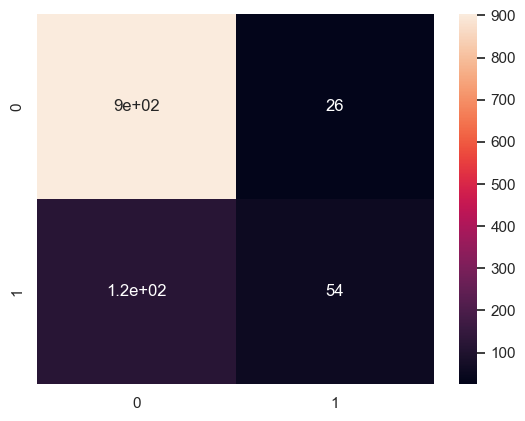

In [110]:
ypred = model.predict(Xtest)
cf = confusion_matrix(ytest, ypred.round())
sns.heatmap(pd.DataFrame(cf) , annot=True)
print(classification_report(ytest,ypred.round()))

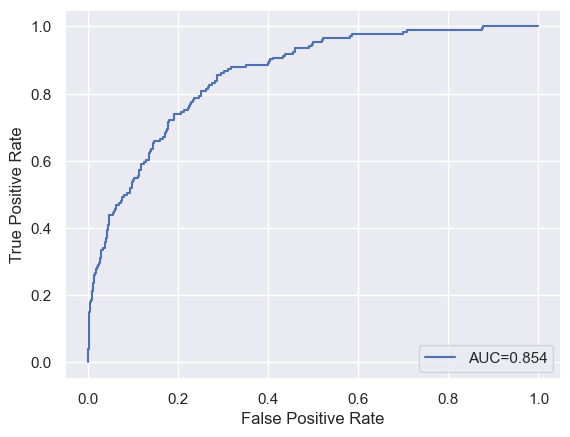

In [111]:
#create ROC curve
fpr, tpr, _ = roc_curve(ytest,  ypred)
auc = roc_auc_score(ytest, ypred)


plt.plot(fpr,tpr,label="AUC="+str(round(auc,3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

 # Rule Induction: RIPPER

### SMOTE Oversampling

In [112]:
import wittgenstein as witt
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import NearMiss


In [113]:
ripper = witt.RIPPER(prune_size=0.001, k=3,random_state=0)
sfs = SFS(ripper, n_features_to_select='auto', scoring='roc_auc', direction="forward", n_jobs=-1)
sfs.fit(X, y)
features= pd.DataFrame(sfs.get_feature_names_out(), columns=['Features'])
X_new = sfs.transform(X)
X_new = pd.DataFrame(X_new, columns = features.Features)

In [114]:
features

Features
0         MinTemp
1     Evaporation
2        Sunshine
3     WindGustDir
4   WindGustSpeed
5    WindSpeed9am
6     Pressure3pm
7        Cloud9am
8         Temp9am
9         Temp3pm
10      RainToday

In [115]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, test_size=0.2, random_state=13)
Xtrain_resampled, ytrain_resampled = smote.fit_resample(Xtrain, ytrain)

In [151]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
metrics_resampled = [[],[],[],[]]
metrics = [[],[],[],[]]
results_resampled = []
results = []
Xtrain0 = np.array(X_new)
ytrain0 = np.array(y)
for train_ix, test_ix in kfold.split(Xtrain0, ytrain0):
    # select rows
    train_X, test_X = Xtrain0[train_ix], Xtrain0[test_ix]
    train_y, test_y = ytrain0[train_ix], ytrain0[test_ix]
    
    # train unbalanced
    ripper = witt.RIPPER(prune_size=0.001, k=3, random_state=0, verbosity = 1)
    ripper.fit(train_X, train_y)
    ypred = ripper.predict(test_X)
    
    metrics = store_metrics(metrics, test_y, ypred)
    results.append([test_y, ypred])
    

    
    
    # train balanced 
    Xtrain_resampled0, ytrain_resampled0 = smote.fit_resample(train_X, train_y)
    ripper = witt.RIPPER(prune_size=0.001, k=3,random_state=0)
    ripper.fit(Xtrain_resampled0, ytrain_resampled0)
    ypred_resampled = ripper.predict(test_X)

    
    metrics_resampled = store_metrics(metrics_resampled, test_y, ypred_resampled)
    results_resampled.append([test_y, ypred_resampled])

    
    



discretizing 10 features

GREW INITIAL RULESET:
[[2=<2.3] V
[2=2.3-4.8] V
[2=4.8-6.7] V
[2=6.7-8.2 ^ 6=<1008.0] V
[2=6.7-8.2 ^ 6=1008.0-1010.3] V
[2=6.7-8.2 ^ 4=46.0-52.0] V
[2=8.2-9.1] V
[2=6.7-8.2] V
[6=<1008.0] V
[2=9.1-9.9 ^ 0=14.2-16.2 ^ 7=2.0-3.0] V
[2=9.1-9.9]]

optimization run 1 of 3

OPTIMIZED RULESET:
[[2=<2.3] V
[2=2.3-4.8] V
[2=4.8-6.7] V
[2=6.7-8.2 ^ 6=<1008.0] V
[2=6.7-8.2 ^ 6=1008.0-1010.3] V
[2=6.7-8.2 ^ 4=46.0-52.0] V
[2=8.2-9.1] V
[2=6.7-8.2] V
[6=<1008.0] V
[2=9.1-9.9 ^ 0=14.2-16.2 ^ 7=2.0-3.0] V
[2=9.1-9.9]]

No changes were made. Halting optimization.
GREW FINAL RULES
[[2=<2.3] V
[2=2.3-4.8] V
[2=4.8-6.7] V
[2=6.7-8.2 ^ 6=<1008.0] V
[2=6.7-8.2 ^ 6=1008.0-1010.3] V
[2=6.7-8.2 ^ 4=46.0-52.0] V
[2=8.2-9.1] V
[2=6.7-8.2] V
[6=<1008.0] V
[2=9.1-9.9 ^ 0=14.2-16.2 ^ 7=2.0-3.0] V
[2=9.1-9.9] V
[2=<2.3] V
[2=2.3-4.8] V
[2=4.8-6.7] V
[2=6.7-8.2 ^ 6=<1008.0] V
[2=6.7-8.2 ^ 6=1008.0-1010.3] V
[2=6.7-8.2 ^ 4=46.0-52.0] V
[2=8.2-9.1] V
[2=6.7-8.2] V
[6=<1008.0] V
[2=9.1-9.9 ^ 0

In [117]:
metrics_resampled = np.array(metrics_resampled)
metrics = np.array(metrics)
results_resampled = np.array(results_resampled)
results = np.array(results)

columns_resampled = ['ROC_AUC_resampled','F1_resampled','Precision_resampled','Recall_resampled']
columns = ['ROC_AUC','F1','Precision','Recall']
metrics_scores = pd.DataFrame(np.concatenate([metrics_resampled.T, metrics.T],axis=1), columns = columns_resampled + columns)
mean_score = np.mean(np.array(metrics_scores), axis=0)
mean_score0 = pd.DataFrame(mean_score.round(3).reshape(2,4), columns = columns, index=['Balanced','Unbalanced'])
mean_score0


ROC_AUC     F1  Precision  Recall
Balanced      0.708  0.411      0.277   0.819
Unbalanced    0.717  0.440      0.319   0.719

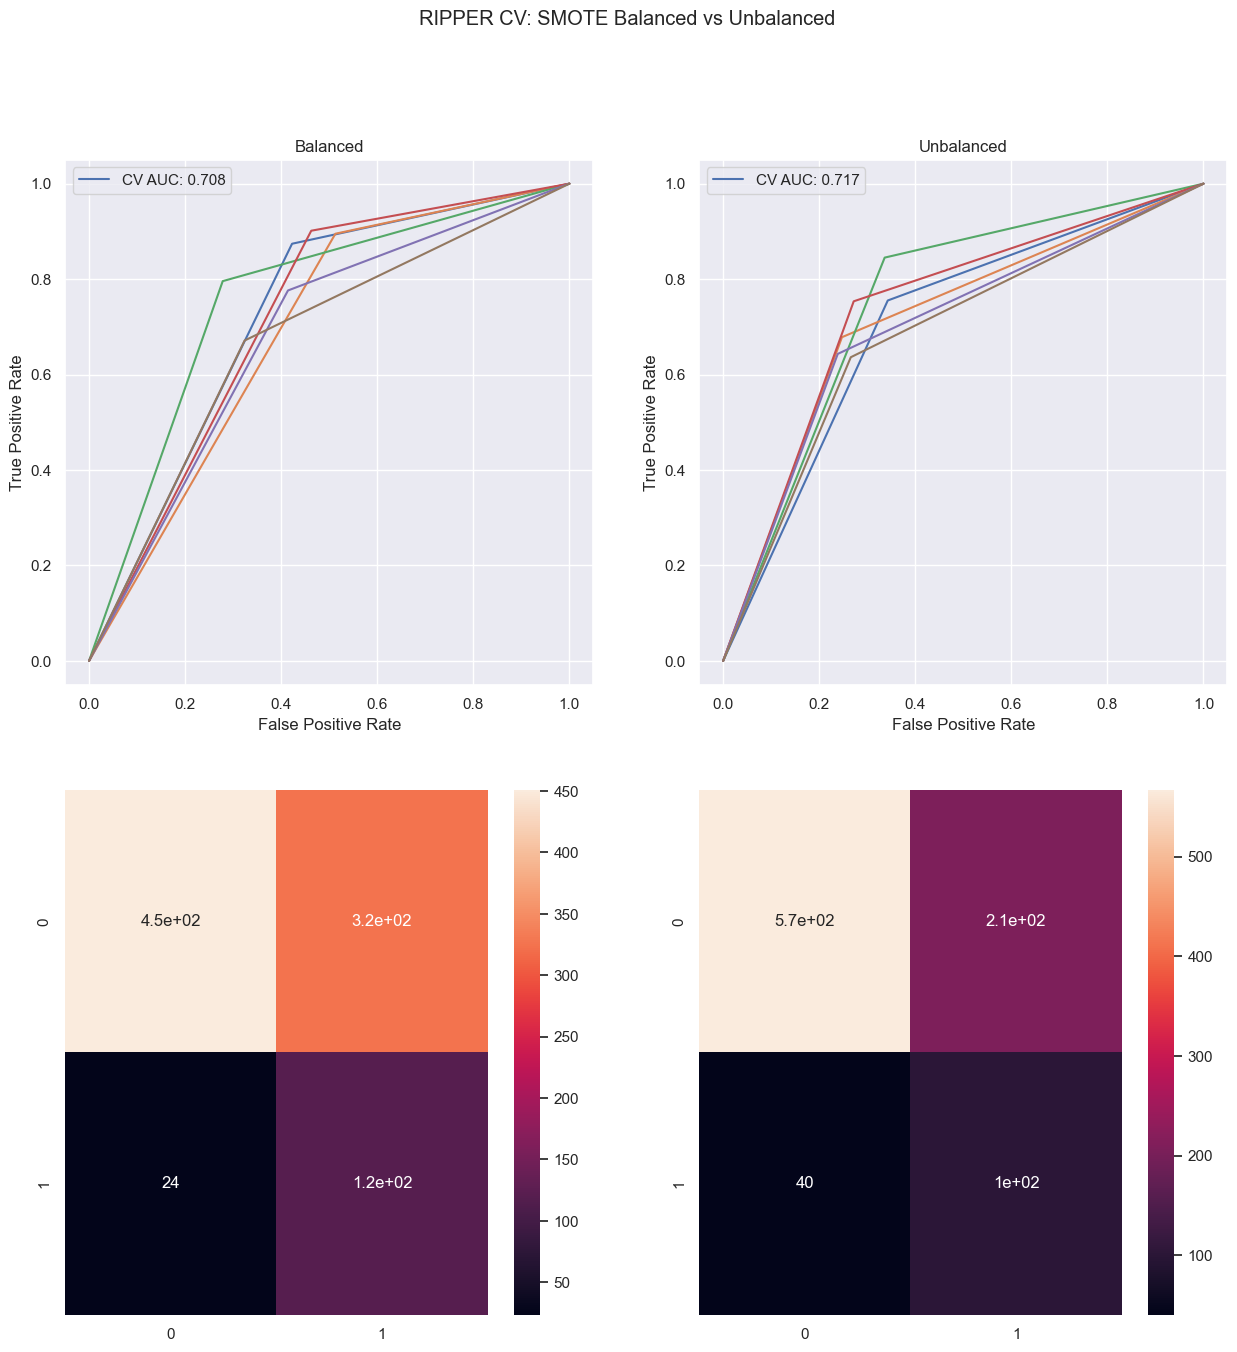

In [118]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle(f'RIPPER CV: SMOTE Balanced vs Unbalanced')
sns.set(font_scale = 1)

cflist = []
cflist_resampled = []
for res_resampled, res in zip(results_resampled, results):

    fpr, tpr, _ = roc_curve(res_resampled[0],  res_resampled[1])
    auc = roc_auc_score(res_resampled[0],  res_resampled[1])
    cf = confusion_matrix(res_resampled[0],  res_resampled[1])
    cflist_resampled.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,0])
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].set_title('Balanced')

    
    
    fpr, tpr, _ = roc_curve(res[0],  res[1])
    auc = roc_auc_score(res[0],  res[1])
    cf = confusion_matrix(res[0],  res[1])
    cflist.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,1])
    axes[0,1].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,1].set_title('Unbalanced')
    
    
axes[0,0].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][0],3)}"])
axes[0,1].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][1],3)}"])

cf = np.median(cflist,axis=0)
cf_resampled = np.median(cflist_resampled,axis=0)
sns.heatmap(pd.DataFrame(cf_resampled) , annot=True, ax = axes[1,0])
sns.heatmap(pd.DataFrame(cf) , annot=True, ax = axes[1,1])   
plt.show()

    
    

### NearMiss Undersampling

In [119]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, test_size=0.2, random_state=13)
Xtrain_resampled, ytrain_resampled = nm.fit_resample(Xtrain, ytrain)

In [120]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
metrics_resampled = [[],[],[],[]]
metrics = [[],[],[],[]]
results_resampled = []
results = []
Xtrain0 = np.array(X_new)
ytrain0 = np.array(y)
for train_ix, test_ix in kfold.split(Xtrain0, ytrain0):
    # select rows
    train_X, test_X = Xtrain0[train_ix], Xtrain0[test_ix]
    train_y, test_y = ytrain0[train_ix], ytrain0[test_ix]
    
    # train unbalanced
    ripper = witt.RIPPER(prune_size=0.001, k=3, random_state=0)
    ripper.fit(train_X, train_y)
    ypred = ripper.predict(test_X)
    
    metrics = store_metrics(metrics, test_y, ypred)
    results.append([test_y, ypred])
    

    
    
    # train balanced 
    Xtrain_resampled0, ytrain_resampled0 = nm.fit_resample(train_X, train_y)
    ripper = witt.RIPPER(prune_size=0.001, k=3,random_state=0)
    ripper.fit(Xtrain_resampled0, ytrain_resampled0)
    ypred_resampled = ripper.predict(test_X)

    
    metrics_resampled = store_metrics(metrics_resampled, test_y, ypred_resampled)
    results_resampled.append([test_y, ypred_resampled])

    
    



In [121]:
metrics_resampled = np.array(metrics_resampled)
metrics = np.array(metrics)
results_resampled = np.array(results_resampled)
results = np.array(results)

columns_resampled = ['ROC_AUC_resampled','F1_resampled','Precision_resampled','Recall_resampled']
columns = ['ROC_AUC','F1','Precision','Recall']
metrics_scores = pd.DataFrame(np.concatenate([metrics_resampled.T, metrics.T],axis=1), columns = columns_resampled + columns)
mean_score = np.mean(np.array(metrics_scores), axis=0)
mean_score0 = pd.DataFrame(mean_score.round(3).reshape(2,4), columns = columns, index=['Balanced','Unbalanced'])
mean_score0


ROC_AUC    F1  Precision  Recall
Balanced      0.626  0.35      0.278   0.495
Unbalanced    0.717  0.44      0.319   0.719

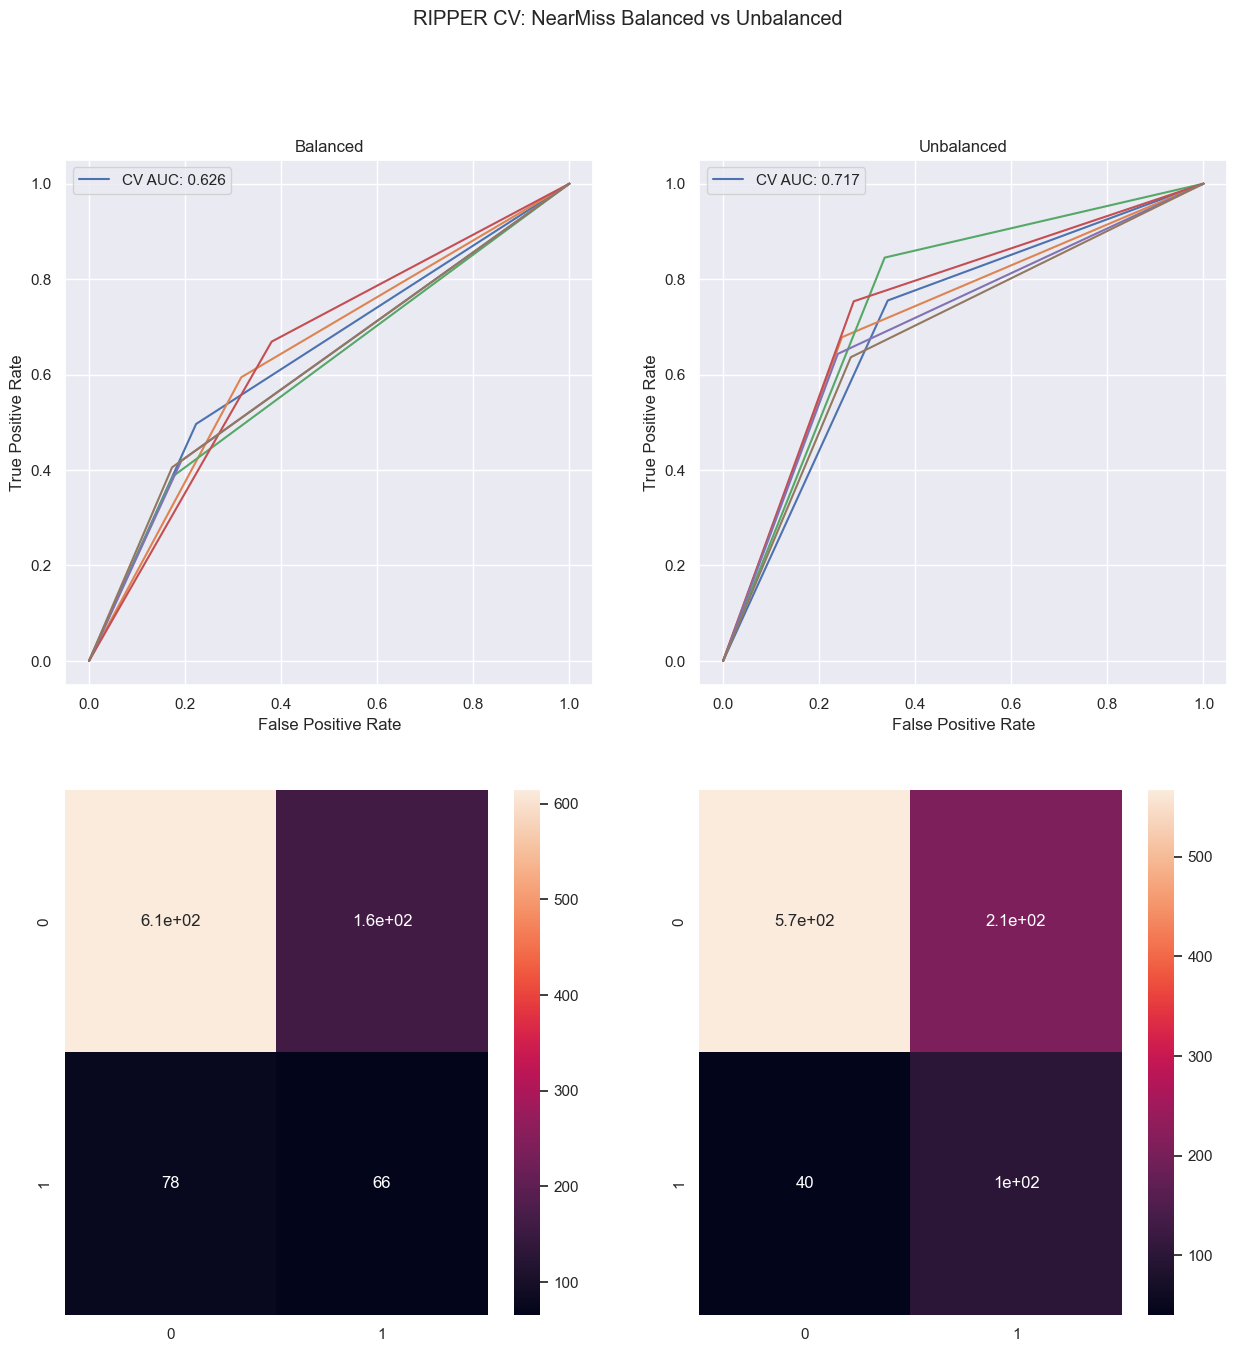

In [122]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle(f'RIPPER CV: NearMiss Balanced vs Unbalanced')
sns.set(font_scale = 1)

cflist = []
cflist_resampled = []
for res_resampled, res in zip(results_resampled, results):

    fpr, tpr, _ = roc_curve(res_resampled[0],  res_resampled[1])
    auc = roc_auc_score(res_resampled[0],  res_resampled[1])
    cf = confusion_matrix(res_resampled[0],  res_resampled[1])
    cflist_resampled.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,0])
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].set_title('Balanced')

    
    
    fpr, tpr, _ = roc_curve(res[0],  res[1])
    auc = roc_auc_score(res[0],  res[1])
    cf = confusion_matrix(res[0],  res[1])
    cflist.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,1])
    axes[0,1].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,1].set_title('Unbalanced')
    
    
axes[0,0].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][0],3)}"])
axes[0,1].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][1],3)}"])

cf = np.median(cflist,axis=0)
cf_resampled = np.median(cflist_resampled,axis=0)
sns.heatmap(pd.DataFrame(cf_resampled) , annot=True, ax = axes[1,0])
sns.heatmap(pd.DataFrame(cf) , annot=True, ax = axes[1,1])   
plt.show()

    
    